<a href="https://colab.research.google.com/github/tatsuhiko-suyama/Something-/blob/main/%EF%BC%92_26_%E7%9B%B8%E9%96%A2%E8%A1%8C%E5%88%97%E3%81%8Crho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize, linprog
from itertools import combinations
from functools import lru_cache

# ---------------------------
# 1. Correlation Matrix Generation Functions
# ---------------------------
def generate_exponential_correlation(n, rho):
    """Generate correlation matrix with exponential decay structure.

    For indices (i,j), the correlation is ρ^|i-j|, creating a structured
    correlation matrix with Toeplitz properties.

    Parameters:
      n   : Dimension of the correlation matrix
      rho : Base correlation parameter (0 ≤ rho < 1)

    Returns:
      R   : n×n correlation matrix with exponential decay structure
    """
    i, j = np.indices((n, n))
    return rho ** np.abs(i - j)

def generate_constant_correlation(n, rho):
    """Generate correlation matrix with constant off-diagonal elements.

    Creates a compound symmetry (equicorrelation) matrix where all
    off-diagonal elements equal rho.

    Parameters:
      n   : Dimension of the correlation matrix
      rho : Correlation coefficient for all pairs of variables

    Returns:
      R   : n×n correlation matrix with all off-diagonal elements equal to rho
    """
    R = np.ones((n, n)) * rho  # Initialize with all elements set to rho
    np.fill_diagonal(R, 1.0)   # Set diagonal elements to 1
    return R

def correlation_to_covariance(R_corr, sigma):
    """Convert correlation matrix to covariance matrix using the relation Σ = DRD,
    where D is a diagonal matrix of standard deviations.

    Parameters:
      R_corr : Correlation matrix
      sigma  : Vector of standard deviations

    Returns:
      Sigma  : Covariance matrix
    """
    D = np.diag(sigma)
    return D @ R_corr @ D

# ---------------------------
# 2. Weighted Covariance Matrix Computation
# ---------------------------
def compute_weighted_covariance(V_list, r_list, w):
    """
    Compute weighted covariance matrix V^w for the robust portfolio optimization.

    The formula is: V^w = Σ w_m V_m - (Σ w_m r_m)(Σ w_m r_m)^T

    Parameters:
      V_list : List of covariance matrices [V₁, V₂, ..., V_M]
      r_list : List of return vectors [r₁, r₂, ..., r_M]
      w      : Model weights [w₁, w₂, ..., w_M]

    Returns:
      V_w    : Weighted covariance matrix
    """
    M = len(V_list)
    n = V_list[0].shape[0]

    # Σ w_m V_m
    V_w = np.zeros((n, n))
    for m in range(M):
        V_w += w[m] * V_list[m]

    # Σ w_m r_m
    r_w = np.zeros(n)
    for m in range(M):
        r_w += w[m] * r_list[m]

    # (Σ w_m r_m)(Σ w_m r_m)^T
    V_w -= np.outer(r_w, r_w)

    return V_w

# ---------------------------
# 3. Branch and Bound Solution for M=3 Case
# ---------------------------
def solve_portfolio_branch_M3(V_w, r1, r2, r3, mu, tol=1e-8):
    """
    Solve the mean-variance portfolio problem for M=3 using branch and bound.

    This function systematically enumerates all possible combinations of active
    and inactive constraints to find the global optimum.

    Parameters:
      V_w : Weighted covariance matrix
      r1  : Return vector for model 1
      r2  : Return vector for model 2
      r3  : Return vector for model 3
      mu  : Target return threshold
      tol : Numerical tolerance

    Returns:
      best_candidate : The optimal solution (case, portfolio, objective)
      candidates     : All feasible candidates
    """
    n = V_w.shape[0]
    invV = np.linalg.inv(V_w)
    candidates = []

    # Helper function: π = 0.5 * invV (sum_i λ_i * r_i)
    def pi_from_lagrange(lmbd_vec, r_list):
        comb = np.zeros(n)
        for lam, r_ in zip(lmbd_vec, r_list):
            comb += lam * r_
        return 0.5 * (invV @ comb)

    # ---------------------------
    # Case 1: All constraints active (r1, r2, r3)
    # ---------------------------
    A3 = np.array([
        [r1.T @ invV @ r1, r1.T @ invV @ r2, r1.T @ invV @ r3],
        [r2.T @ invV @ r1, r2.T @ invV @ r2, r2.T @ invV @ r3],
        [r3.T @ invV @ r1, r3.T @ invV @ r2, r3.T @ invV @ r3]
    ])
    b3 = 2 * mu * np.ones(3)
    try:
        lam3 = np.linalg.solve(A3, b3)  # λ₁, λ₂, λ₃
        if all(l > tol for l in lam3):
            pi_case1 = pi_from_lagrange(lam3, [r1, r2, r3])
            # Verify all constraints are satisfied as equalities
            c1 = r1.T @ pi_case1
            c2 = r2.T @ pi_case1
            c3 = r3.T @ pi_case1
            if (abs(c1 - mu) < tol) and (abs(c2 - mu) < tol) and (abs(c3 - mu) < tol):
                obj1 = pi_case1.T @ V_w @ pi_case1
                candidates.append(('Case1', pi_case1, obj1))
    except np.linalg.LinAlgError:
        pass  # Skip if matrix is singular

    # ---------------------------
    # Case 2: r1, r2 active; r3 inactive
    # ---------------------------
    A2_12 = np.array([
        [r1.T @ invV @ r1, r1.T @ invV @ r2],
        [r2.T @ invV @ r1, r2.T @ invV @ r2]
    ])
    b2_12 = 2 * mu * np.ones(2)
    try:
        lam2_12 = np.linalg.solve(A2_12, b2_12)  # λ₁, λ₂
        if all(l > tol for l in lam2_12):
            pi_case2 = pi_from_lagrange(lam2_12, [r1, r2])
            # Verify constraints: r1, r2 active (equality), r3 inactive (strict inequality)
            c1 = r1.T @ pi_case2
            c2 = r2.T @ pi_case2
            c3 = r3.T @ pi_case2
            if (abs(c1 - mu) < tol) and (abs(c2 - mu) < tol) and (c3 > mu + tol):
                obj2 = pi_case2.T @ V_w @ pi_case2
                candidates.append(('Case2', pi_case2, obj2))
    except np.linalg.LinAlgError:
        pass

    # ---------------------------
    # Case 3: r1, r3 active; r2 inactive
    # ---------------------------
    A2_13 = np.array([
        [r1.T @ invV @ r1, r1.T @ invV @ r3],
        [r3.T @ invV @ r1, r3.T @ invV @ r3]
    ])
    b2_13 = 2 * mu * np.ones(2)
    try:
        lam2_13 = np.linalg.solve(A2_13, b2_13)  # λ₁, λ₃
        if all(l > tol for l in lam2_13):
            pi_case3 = pi_from_lagrange(lam2_13, [r1, r3])
            c1 = r1.T @ pi_case3
            c2 = r2.T @ pi_case3
            c3 = r3.T @ pi_case3
            if (abs(c1 - mu) < tol) and (c2 > mu + tol) and (abs(c3 - mu) < tol):
                obj3 = pi_case3.T @ V_w @ pi_case3
                candidates.append(('Case3', pi_case3, obj3))
    except np.linalg.LinAlgError:
        pass

    # ---------------------------
    # Case 4: r2, r3 active; r1 inactive
    # ---------------------------
    A2_23 = np.array([
        [r2.T @ invV @ r2, r2.T @ invV @ r3],
        [r3.T @ invV @ r2, r3.T @ invV @ r3]
    ])
    b2_23 = 2 * mu * np.ones(2)
    try:
        lam2_23 = np.linalg.solve(A2_23, b2_23)  # λ₂, λ₃
        if all(l > tol for l in lam2_23):
            pi_case4 = pi_from_lagrange(lam2_23, [r2, r3])
            c1 = r1.T @ pi_case4
            c2 = r2.T @ pi_case4
            c3 = r3.T @ pi_case4
            if (c1 > mu + tol) and (abs(c2 - mu) < tol) and (abs(c3 - mu) < tol):
                obj4 = pi_case4.T @ V_w @ pi_case4
                candidates.append(('Case4', pi_case4, obj4))
    except np.linalg.LinAlgError:
        pass

    # ---------------------------
    # Case 5: r1 active only; r2, r3 inactive
    # ---------------------------
    denom1 = r1.T @ invV @ r1
    if abs(denom1) > tol:
        pi_case5 = (mu * (invV @ r1)) / denom1
        c1 = r1.T @ pi_case5
        c2 = r2.T @ pi_case5
        c3 = r3.T @ pi_case5
        # Verify: r1=μ, r2>μ, r3>μ
        if abs(c1 - mu) < tol and (c2 > mu + tol) and (c3 > mu + tol):
            obj5 = pi_case5.T @ V_w @ pi_case5
            candidates.append(('Case5', pi_case5, obj5))

    # ---------------------------
    # Case 6: r2 active only; r1, r3 inactive
    # ---------------------------
    denom2 = r2.T @ invV @ r2
    if abs(denom2) > tol:
        pi_case6 = (mu * (invV @ r2)) / denom2
        c1 = r1.T @ pi_case6
        c2 = r2.T @ pi_case6
        c3 = r3.T @ pi_case6
        if (c1 > mu + tol) and abs(c2 - mu) < tol and (c3 > mu + tol):
            obj6 = pi_case6.T @ V_w @ pi_case6
            candidates.append(('Case6', pi_case6, obj6))

    # ---------------------------
    # Case 7: r3 active only; r1, r2 inactive
    # ---------------------------
    denom3 = r3.T @ invV @ r3
    if abs(denom3) > tol:
        pi_case7 = (mu * (invV @ r3)) / denom3
        c1 = r1.T @ pi_case7
        c2 = r2.T @ pi_case7
        c3 = r3.T @ pi_case7
        if (c1 > mu + tol) and (c2 > mu + tol) and abs(c3 - mu) < tol:
            obj7 = pi_case7.T @ V_w @ pi_case7
            candidates.append(('Case7', pi_case7, obj7))

    if len(candidates) == 0:
        return None, None

    # Return candidate with minimum objective value
    best_candidate = min(candidates, key=lambda x: x[2])
    return best_candidate, candidates

# ---------------------------
# 4. Branch and Bound Solution for M=2 Case
# ---------------------------
def solve_portfolio_branch_M2(V_w, r1, r2, mu, tol=1e-8):
    """
    Solve the mean-variance portfolio problem for M=2 using branch and bound.

    Parameters:
      V_w : Weighted covariance matrix
      r1  : Return vector for model 1
      r2  : Return vector for model 2
      mu  : Target return threshold
      tol : Numerical tolerance

    Returns:
      best_candidate : The optimal solution (case, portfolio, objective)
      candidates     : All feasible candidates
    """
    n = V_w.shape[0]
    invV = np.linalg.inv(V_w)
    candidates = []

    # Helper function: π = 0.5 * invV (sum_i λ_i * r_i)
    def pi_from_lagrange(lmbd_vec, r_list):
        comb = np.zeros(n)
        for lam, r_ in zip(lmbd_vec, r_list):
            comb += lam * r_
        return 0.5 * (invV @ comb)

    # ---------------------------
    # Case 1: Both constraints active (r1, r2)
    # ---------------------------
    A2 = np.array([
        [r1.T @ invV @ r1, r1.T @ invV @ r2],
        [r2.T @ invV @ r1, r2.T @ invV @ r2]
    ])
    b2 = 2 * mu * np.ones(2)
    try:
        lam2 = np.linalg.solve(A2, b2)  # λ₁, λ₂
        if all(l > tol for l in lam2):
            pi_case1 = pi_from_lagrange(lam2, [r1, r2])
            # Verify all constraints are satisfied as equalities
            c1 = r1.T @ pi_case1
            c2 = r2.T @ pi_case1
            if (abs(c1 - mu) < tol) and (abs(c2 - mu) < tol):
                obj1 = pi_case1.T @ V_w @ pi_case1
                candidates.append(('Case1', pi_case1, obj1))
    except np.linalg.LinAlgError:
        pass  # Skip if matrix is singular

    # ---------------------------
    # Case 2: r1 active only; r2 inactive
    # ---------------------------
    denom1 = r1.T @ invV @ r1
    if abs(denom1) > tol:
        pi_case2 = (mu * (invV @ r1)) / denom1
        c1 = r1.T @ pi_case2
        c2 = r2.T @ pi_case2
        # Verify: r1=μ, r2>μ
        if abs(c1 - mu) < tol and (c2 > mu + tol):
            obj2 = pi_case2.T @ V_w @ pi_case2
            candidates.append(('Case2', pi_case2, obj2))

    # ---------------------------
    # Case 3: r2 active only; r1 inactive
    # ---------------------------
    denom2 = r2.T @ invV @ r2
    if abs(denom2) > tol:
        pi_case3 = (mu * (invV @ r2)) / denom2
        c1 = r1.T @ pi_case3
        c2 = r2.T @ pi_case3
        if (c1 > mu + tol) and abs(c2 - mu) < tol:
            obj3 = pi_case3.T @ V_w @ pi_case3
            candidates.append(('Case3', pi_case3, obj3))

    if len(candidates) == 0:
        return None, None

    # Return candidate with minimum objective value
    best_candidate = min(candidates, key=lambda x: x[2])
    return best_candidate, candidates

# ---------------------------
# 5. NLP Solution Using SLSQP
# ---------------------------
def solve_portfolio_M3_solver(V_w, R, mu, tol=1e-8):
    """
    Solve the mean-variance portfolio problem for M=3 using SLSQP optimizer.

    Parameters:
      V_w : Weighted covariance matrix
      R   : Matrix of return vectors [r₁; r₂; r₃]
      mu  : Target return threshold
      tol : Convergence tolerance

    Returns:
      sol : Solution object from the optimizer
    """
    n = V_w.shape[0]

    def objective(pi):
        return pi @ V_w @ pi

    def grad_objective(pi):
        return 2 * V_w @ pi

    # Define inequality constraints: R @ π - μ ≥ 0
    def constraints_fun(pi):
        return R @ pi - mu

    def constraints_jac(pi):
        return R

    constraints = [{
        'type': 'ineq',
        'fun': constraints_fun,
        'jac': constraints_jac
    }]

    # Get initial point using linear programming
    A_ub = -R
    b_ub = -mu * np.ones(R.shape[0])
    bounds = [(None, None)] * n
    res_lp = linprog(c=np.zeros(n), A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
    pi0 = res_lp.x if res_lp.success else np.ones(n)

    sol = minimize(objective, pi0, jac=grad_objective,
                   constraints=constraints, method='SLSQP', tol=tol)
    return sol

# ---------------------------
# 6. Cached Solver for Inner Minimization Problem
# ---------------------------
# Global variables for caching
V_list_global = None
r_list_global = None

@lru_cache(maxsize=1024)
def solve_inner_min_problem_cached(w_tuple, mu, V_list_id, r_list_id):
    """
    Cached solver for the inner minimization problem.

    Parameters:
      w_tuple   : Model weights as tuple (for caching)
      mu        : Target return threshold
      V_list_id : ID hash of V_list (for caching)
      r_list_id : ID hash of r_list (for caching)

    Returns:
      pi        : Optimal portfolio
      obj       : Objective value
      success   : Success flag
    """
    global V_list_global, r_list_global
    w = np.array(w_tuple)

    # Get global variables
    V_list = V_list_global
    r_list = r_list_global

    # Compute weighted covariance matrix
    V_w = compute_weighted_covariance(V_list, r_list, w)

    # Create return matrix
    R_matrix = np.vstack(r_list)

    # Solve inner minimization problem
    sol = solve_portfolio_M3_solver(V_w, R_matrix, mu)

    if sol.success:
        return sol.x, sol.fun, True
    else:
        return None, np.inf, False

def solve_inner_min_problem(V_list, r_list, w, mu):
    """Wrapper for cached inner minimization solver"""
    global V_list_global, r_list_global

    # Save to global variables
    V_list_global = V_list
    r_list_global = r_list

    # Generate IDs
    V_list_id = id(tuple(map(id, V_list)))
    r_list_id = id(tuple(map(id, r_list)))

    return solve_inner_min_problem_cached(tuple(w), mu, V_list_id, r_list_id)

# ---------------------------
# 7. MaxMin Vertex and Edge Search
# ---------------------------
def solve_maxmin_vertices_edges(V_list, r_list, mu):
    """
    Efficiently search vertices and edges of the simplex for MaxMin problem.

    Parameters:
      V_list : List of covariance matrices
      r_list : List of return vectors
      mu     : Target return threshold

    Returns:
      w_opt  : Optimal model weights
      pi_opt : Optimal portfolio
      obj_val: Objective value
      results: All search results
    """
    M = len(V_list)

    # 1. Process all vertices
    vertices = np.eye(M)  # Identity matrix represents vertices
    vertex_results = []

    for m, w in enumerate(vertices):
        pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)
        if success:
            vertex_results.append({
                'type': 'vertex',
                'w': w.copy(),
                'pi': pi,
                'obj': obj,
                'success': success,
                'vertex_idx': m
            })

    # 2. Process points along edges
    edge_results = []
    alphas = np.linspace(0.1, 0.9, 9)  # Exploration points along edges

    for i, j in combinations(range(M), 2):
        for alpha in alphas:
            w = np.zeros(M)
            w[i] = alpha
            w[j] = 1 - alpha

            pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)

            if success:
                edge_results.append({
                    'type': 'edge',
                    'w': w.copy(),
                    'pi': pi,
                    'obj': obj,
                    'success': success,
                    'edge': (i, j),
                    'alpha': alpha
                })

    # 3. Combine results and find optimal solution
    results = vertex_results + edge_results

    valid_results = [r for r in results if r['success']]
    if not valid_results:
        return None, None, np.nan, results

    best_result = max(valid_results, key=lambda r: r['obj'])

    return best_result['w'], best_result['pi'], best_result['obj'], results

# ---------------------------
# 8. MaxMin Direct Optimization
# ---------------------------
def solve_maxmin_direct_optimization(V_list, r_list, mu, max_iter=10):
    """
    Solve MaxMin problem using direct optimization on the simplex.

    Parameters:
      V_list  : List of covariance matrices
      r_list  : List of return vectors
      mu      : Target return threshold
      max_iter: Maximum number of iterations with different starting points

    Returns:
      w_opt   : Optimal model weights
      pi_opt  : Optimal portfolio
      obj_val : Objective value
      results : Optimization results
    """
    M = len(V_list)

    # Function for inner minimization problem (negated for maximization)
    def neg_inner_min_obj(w):
        """Negated inner objective function for maximization"""
        pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)
        if success:
            return -obj  # Negate for maximization
        else:
            return 1e10  # Large penalty for infeasible points

    # Simplex constraints
    bounds = [(0, 1)] * M  # Each w in [0,1]

    # Sum-to-one equality constraint
    constraints = [{
        'type': 'eq',
        'fun': lambda w: np.sum(w) - 1,
        'jac': lambda w: np.ones(M)
    }]

    # Track best results
    best_w = None
    best_pi = None
    best_obj = -np.inf
    all_results = []

    # Multiple optimization runs with different starting points
    for _ in range(max_iter):
        # Random starting point on the simplex
        w0 = np.random.rand(M)
        w0 /= np.sum(w0)  # Normalize to sum to 1

        # Run optimization
        sol = minimize(
            neg_inner_min_obj,
            w0,
            bounds=bounds,
            constraints=constraints,
            method='SLSQP',
            options={'disp': False, 'maxiter': 1000}
        )

        if sol.success:
            # Get optimal portfolio for this w
            w_opt = sol.x
            pi_opt, obj_opt, success = solve_inner_min_problem(V_list, r_list, w_opt, mu)

            all_results.append({
                'w': w_opt,
                'pi': pi_opt,
                'obj': obj_opt,
                'success': success,
                'initial_w': w0
            })

            # Update best solution if better
            if success and obj_opt > best_obj:
                best_w = w_opt
                best_pi = pi_opt
                best_obj = obj_opt

    # Return results
    return best_w, best_pi, best_obj, all_results

# ---------------------------
# 9. MaxMin Random Search
# ---------------------------
def solve_maxmin_random_search(V_list, r_list, mu, n_samples=1000):
    """
    Solve MaxMin problem using random search on the simplex.

    Parameters:
      V_list   : List of covariance matrices
      r_list   : List of return vectors
      mu       : Target return threshold
      n_samples: Number of random samples

    Returns:
      w_opt    : Optimal model weights
      pi_opt   : Optimal portfolio
      obj_val  : Objective value
      results  : Search results
    """
    M = len(V_list)

    # Generate random points on the M-dimensional simplex
    def generate_simplex_points(n):
        """Efficiently generate points on the M-dimensional simplex using Dirichlet distribution"""
        # Generate unit Gamma variates and normalize
        points = np.random.gamma(shape=1.0, scale=1.0, size=(n, M))
        return points / np.sum(points, axis=1)[:, np.newaxis]

    # Generate random points
    w_samples = generate_simplex_points(n_samples)

    # Initialize arrays for results
    obj_vals = np.zeros(n_samples)
    pi_solutions = [None] * n_samples
    success_flags = np.zeros(n_samples, dtype=bool)

    # Solve inner minimization problem for all sample points
    for i, w in enumerate(w_samples):
        pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)
        obj_vals[i] = obj
        pi_solutions[i] = pi
        success_flags[i] = success

        # Progress indicator
        if (i + 1) % 100 == 0:
            print(f"  Random search: {i+1}/{n_samples} completed")

    # Find best solution among successful ones
    valid_indices = np.where(success_flags)[0]
    if len(valid_indices) == 0:
        return None, None, np.nan, {}

    best_idx = valid_indices[np.argmax(obj_vals[valid_indices])]

    results = {
        'w_samples': w_samples,
        'obj_vals': obj_vals,
        'pi_solutions': pi_solutions,
        'success_flags': success_flags
    }

    return w_samples[best_idx], pi_solutions[best_idx], obj_vals[best_idx], results

# ---------------------------
# 10. Comprehensive MaxMin Solution
# ---------------------------
def solve_maxmin_comprehensive(V_list, r_list, mu, random_samples=1000, direct_opt_iters=5):
    """
    Comprehensive MaxMin problem solver combining multiple approaches.

    Parameters:
      V_list         : List of covariance matrices
      r_list         : List of return vectors
      mu             : Target return threshold
      random_samples : Number of random samples
      direct_opt_iters: Number of direct optimization iterations

    Returns:
      best_method    : Best method found
      w_opt          : Optimal model weights
      pi_opt         : Optimal portfolio
      obj_val        : Objective value
    """
    M = len(V_list)
    results = {}

    # 1. Vertex search (for any M)
    print("Searching vertices in M dimensions...")
    vertices = np.eye(M)
    vertex_results = []

    for m, w in enumerate(vertices):
        pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)
        if success:
            vertex_results.append({
                'type': 'vertex',
                'w': w.copy(),
                'pi': pi,
                'obj': obj,
                'success': success,
                'vertex_idx': m
            })

    # Get best vertex result
    if vertex_results:
        best_vertex = max(vertex_results, key=lambda r: r['obj'])
        results['vertex'] = {
            'w': best_vertex['w'],
            'pi': best_vertex['pi'],
            'obj': best_vertex['obj'],
            'details': vertex_results
        }
    else:
        results['vertex'] = None

    # 2. Edge search (for any M)
    print("Searching edges in M dimensions...")
    edge_results = []
    alphas = np.linspace(0.1, 0.9, 9)

    for i, j in combinations(range(M), 2):
        for alpha in alphas:
            w = np.zeros(M)
            w[i] = alpha
            w[j] = 1 - alpha

            pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)

            if success:
                edge_results.append({
                    'type': 'edge',
                    'w': w.copy(),
                    'pi': pi,
                    'obj': obj,
                    'success': success,
                    'edge': (i, j),
                    'alpha': alpha
                })

    # Get best edge result
    if edge_results:
        best_edge = max(edge_results, key=lambda r: r['obj'])
        results['edge'] = {
            'w': best_edge['w'],
            'pi': best_edge['pi'],
            'obj': best_edge['obj'],
            'details': edge_results
        }
    else:
        results['edge'] = None

    # 3. Random search
    print(f"Performing random search on M-dimensional simplex ({random_samples} samples)...")
    rand_w_opt, rand_pi_opt, rand_obj_val, rand_details = solve_maxmin_random_search(
        V_list, r_list, mu, n_samples=random_samples)

    if rand_w_opt is not None:
        results['random'] = {
            'w': rand_w_opt,
            'pi': rand_pi_opt,
            'obj': rand_obj_val,
            'details': rand_details
        }
    else:
        results['random'] = None

    # 4. Direct optimization
    print(f"Running direct optimization ({direct_opt_iters} iterations)...")
    direct_w_opt, direct_pi_opt, direct_obj_val, direct_details = solve_maxmin_direct_optimization(
        V_list, r_list, mu, max_iter=direct_opt_iters)

    if direct_w_opt is not None:
        results['direct'] = {
            'w': direct_w_opt,
            'pi': direct_pi_opt,
            'obj': direct_obj_val,
            'details': direct_details
        }
    else:
        results['direct'] = None

    # 5. Select best method
    valid_methods = [method for method, res in results.items() if res is not None]
    if not valid_methods:
        return None, None, None, np.nan

    best_method = max(valid_methods, key=lambda m: results[m]['obj'])
    best_result = results[best_method]

    return best_method, best_result['w'], best_result['pi'], best_result['obj']

# ---------------------------
# 11. Visualization Functions
# ---------------------------
def plot_m_dim_results(w_samples, obj_vals, success_flags, best_w=None, method="PCA"):
    """
    Visualize results on M-dimensional simplex using dimensionality reduction.

    Parameters:
      w_samples    : Sample points on the simplex
      obj_vals     : Objective values at sample points
      success_flags: Success flags for each sample
      best_w       : Optional optimal weights to highlight
      method       : Dimensionality reduction method ("PCA" or "TSNE")
    """
    try:
        from sklearn.decomposition import PCA
        from sklearn.manifold import TSNE
    except ImportError:
        print("Warning: scikit-learn is not installed. PCA/TSNE visualization is not available.")
        return None

    # Extract valid points
    valid_indices = np.where(success_flags)[0]
    if len(valid_indices) == 0:
        print("No valid data for visualization")
        return None

    valid_w = w_samples[valid_indices]
    valid_obj = obj_vals[valid_indices]

    # Apply dimensionality reduction
    if method == "PCA":
        reducer = PCA(n_components=2)
    else:  # TSNE
        reducer = TSNE(n_components=2, perplexity=min(30, len(valid_w)-1))

    w_2d = reducer.fit_transform(valid_w)

    # Create scatter plot
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(w_2d[:, 0], w_2d[:, 1], c=valid_obj,
                         cmap='viridis', alpha=0.8, s=50, edgecolors='w')
    plt.colorbar(scatter, label='Objective Value')

    # Highlight optimal point if provided
    if best_w is not None:
        best_w_2d = reducer.transform(best_w.reshape(1, -1))
        ax.plot(best_w_2d[0, 0], best_w_2d[0, 1], 'ro', markersize=10)
        ax.text(best_w_2d[0, 0], best_w_2d[0, 1], 'Optimal',
                color='red', ha='center', va='bottom')

    ax.set_title(f'Objective Values on M-dimensional Simplex ({method} Visualization)')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    plt.tight_layout()

    return fig

# ---------------------------
# 12. Comparative Analysis Function
# ---------------------------
def run_comparative_analysis(n, sigma, mu_list, correlation_types=['exponential', 'constant']):
    """
    Run comparative analysis between different correlation structures.

    Parameters:
      n              : Number of assets
      sigma          : Standard deviation vector
      mu_list        : List of target returns to test
      correlation_types: List of correlation types to compare

    Returns:
      results        : Dictionary of results for each correlation type
    """
    comparative_results = {}

    # Model parameters
    M = 3  # Number of models

    # Common parameters across all correlation types
    rho_list = [0.3, 0.5, 0.7]  # Correlation parameters

    # Return vectors (same for all correlation types)
    r1 = np.array([0.02, 0.04, 0.06, 0.08, 0.10])
    r2 = np.array([0.01, 0.03, 0.05, 0.07, 0.09])
    r3 = np.array([0.015, 0.035, 0.055, 0.075, 0.095])
    r_list = [r1, r2, r3]

    # Run analysis for each correlation type
    for corr_type in correlation_types:
        print(f"\n\n{'='*50}")
        print(f"ANALYSIS WITH {corr_type.upper()} CORRELATION STRUCTURE")
        print(f"{'='*50}")

        # Generate covariance matrices with appropriate correlation structure
        V_list = []
        for rho in rho_list:
            if corr_type == 'exponential':
                correlation = generate_exponential_correlation(n, rho)
            elif corr_type == 'constant':
                correlation = generate_constant_correlation(n, rho)
            else:
                raise ValueError(f"Unknown correlation type: {corr_type}")

            V = correlation_to_covariance(correlation, sigma)
            V_list.append(V)

        # Store eigenvalues of each covariance matrix for analysis
        eigenvalues = []
        for i, V in enumerate(V_list):
            eigvals = np.linalg.eigvals(V)
            eigenvalues.append({
                'model': i+1,
                'rho': rho_list[i],
                'eigenvalues': np.sort(eigvals)[::-1],  # Sort in descending order
                'condition_number': np.max(eigvals)/np.min(eigvals)
            })

        # Results for each target return
        mu_results = []

        for mu in mu_list:
            print(f"\nTarget return μ = {mu}")

            # Solve MaxMin problem
            ve_w_opt, ve_pi_opt, ve_obj_val, ve_results = solve_maxmin_vertices_edges(
                V_list, r_list, mu)

            if ve_w_opt is not None:
                print(f"Optimal model weights w* = {ve_w_opt}")
                print(f"Optimal portfolio π* = {ve_pi_opt}")
                print(f"Optimal value (MaxMin) = {ve_obj_val}")

                # Check return constraints
                returns = np.array([r @ ve_pi_opt for r in r_list])
                for i, ret in enumerate(returns):
                    print(f"Model {i+1} return: {ret:.6f} (≥ {mu})")

                # Determine optimal location (vertex or edge)
                best_result = max([r for r in ve_results if r['success']],
                                  key=lambda r: r['obj'])
                if best_result['type'] == 'vertex':
                    model_idx = np.argmax(best_result['w'])
                    location = f"Vertex (Model {model_idx+1})"
                else:  # edge
                    i, j = best_result['edge']
                    alpha = best_result['alpha']
                    location = f"Edge between Models {i+1} and {j+1} (α = {alpha:.2f})"
            else:
                print("No valid solution found.")
                location = "None"

            # Save results
            mu_results.append({
                'mu': mu,
                'w_opt': ve_w_opt,
                'pi_opt': ve_pi_opt,
                'obj_val': ve_obj_val,
                'location': location
            })

        # Save all results for this correlation type
        comparative_results[corr_type] = {
            'eigenvalues': eigenvalues,
            'mu_results': mu_results
        }

    # Create comparative summary dataframe
    summary_rows = []

    for corr_type in correlation_types:
        for result in comparative_results[corr_type]['mu_results']:
            if result['w_opt'] is not None:
                summary_rows.append({
                    'Correlation Type': corr_type,
                    'Target Return (μ)': result['mu'],
                    'Objective Value': result['obj_val'],
                    'Optimal Location': result['location'],
                    'Weights': str(np.round(result['w_opt'], 3))
                })

    comparative_summary = pd.DataFrame(summary_rows)
    print("\n\nCOMPARATIVE SUMMARY:")
    print(comparative_summary)

    return comparative_results, comparative_summary

# ---------------------------
# Main Function
# ---------------------------
def main():
    # Global variables initialization
    global V_list_global, r_list_global
    V_list_global = None
    r_list_global = None

    # Fixed parameters
    n = 5  # Number of assets
    sigma = np.array([0.2, 0.25, 0.30, 0.35, 0.40])  # Standard deviations
    mu_list = [0.01, 0.05, 0.10]  # Target returns

    # Run comparative analysis
    comparative_results, summary = run_comparative_analysis(
        n, sigma, mu_list,
        correlation_types=['exponential', 'constant']
    )

    # Visualize comparative results
    for mu in mu_list:
        plt.figure(figsize=(12, 6))

        # Extract data for this target return
        exp_result = next((r for r in comparative_results['exponential']['mu_results']
                          if r['mu'] == mu), None)
        const_result = next((r for r in comparative_results['constant']['mu_results']
                           if r['mu'] == mu), None)

        # Plot bar chart comparing objective values
        labels = ['Exponential Correlation', 'Constant Correlation']
        values = [
            exp_result['obj_val'] if exp_result and exp_result['obj_val'] is not None else 0,
            const_result['obj_val'] if const_result and const_result['obj_val'] is not None else 0
        ]

        plt.bar(labels, values, color=['skyblue', 'lightgreen'])
        plt.title(f'Comparison of MaxMin Objective Values (μ={mu})')
        plt.ylabel('Objective Value')
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Add text annotations
        for i, v in enumerate(values):
            if v > 0:
                plt.text(i, v + 0.0001, f'{v:.6f}',
                        ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.savefig(f"correlation_comparison_mu_{mu}.png")
        plt.close()

    # Return results
    return comparative_results, summary

if __name__ == "__main__":
    comparative_results, summary = main()



ANALYSIS WITH EXPONENTIAL CORRELATION STRUCTURE

Target return μ = 0.01
Optimal model weights w* = [0. 0. 1.]
Optimal portfolio π* = [-0.05631001  0.03675027  0.02743913  0.02307924  0.07192321]
Optimal value (MaxMin) = 0.0016181311269139777
Model 1 return: 0.011029 (≥ 0.01)
Model 2 return: 0.010000 (≥ 0.01)
Model 3 return: 0.010514 (≥ 0.01)

Target return μ = 0.05
Optimal model weights w* = [0. 0. 1.]
Optimal portfolio π* = [-0.28155003  0.18375137  0.13719566  0.11539618  0.35961604]
Optimal value (MaxMin) = 0.04045327817284946
Model 1 return: 0.055144 (≥ 0.05)
Model 2 return: 0.050000 (≥ 0.05)
Model 3 return: 0.052572 (≥ 0.05)

Target return μ = 0.1
Optimal model weights w* = [0. 0. 1.]
Optimal portfolio π* = [-0.56310006  0.36750275  0.27439132  0.23079237  0.71923207]
Optimal value (MaxMin) = 0.16181311269139784
Model 1 return: 0.110288 (≥ 0.1)
Model 2 return: 0.100000 (≥ 0.1)
Model 3 return: 0.105144 (≥ 0.1)


ANALYSIS WITH CONSTANT CORRELATION STRUCTURE

Target return μ = 0.01

In [ ]:
summary

,Correlation Type,Target Return (μ),Objective Value,Optimal Location,Weights
0,exponential,0.01,0.001618,Vertex (Model 3),[0. 0. 1.]
1,exponential,0.05,0.040453,Vertex (Model 3),[0. 0. 1.]
2,exponential,0.10,0.161813,Vertex (Model 3),[0. 0. 1.]
3,constant,0.01,0.001204,Edge between Models 1 and 2 (α = 0.30),[0.3 0.7 0. ]
4,constant,0.05,0.030100,Edge between Models 1 and 2 (α = 0.30),[0.3 0.7 0. ]
5,constant,0.10,0.120402,Edge between Models 1 and 2 (α = 0.30),[0.3 0.7 0. ]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize, linprog
from itertools import combinations
from functools import lru_cache

# ---------------------------
# 1. Correlation Matrix Generation Functions
# ---------------------------
def generate_exponential_correlation(n, rho):
    """Generate correlation matrix with exponential decay structure.

    For indices (i,j), the correlation is ρ^|i-j|, creating a structured
    correlation matrix with Toeplitz properties.

    Parameters:
      n   : Dimension of the correlation matrix
      rho : Base correlation parameter (0 ≤ rho < 1)

    Returns:
      R   : n×n correlation matrix with exponential decay structure
    """
    i, j = np.indices((n, n))
    return rho ** np.abs(i - j)

def generate_constant_correlation(n, rho):
    """Generate correlation matrix with constant off-diagonal elements.

    Creates a compound symmetry (equicorrelation) matrix where all
    off-diagonal elements equal rho.

    Parameters:
      n   : Dimension of the correlation matrix
      rho : Correlation coefficient for all pairs of variables

    Returns:
      R   : n×n correlation matrix with all off-diagonal elements equal to rho
    """
    R = np.ones((n, n)) * rho  # Initialize with all elements set to rho
    np.fill_diagonal(R, 1.0)   # Set diagonal elements to 1
    return R

def correlation_to_covariance(R_corr, sigma):
    """Convert correlation matrix to covariance matrix using the relation Σ = DRD,
    where D is a diagonal matrix of standard deviations.

    Parameters:
      R_corr : Correlation matrix
      sigma  : Vector of standard deviations

    Returns:
      Sigma  : Covariance matrix
    """
    D = np.diag(sigma)
    return D @ R_corr @ D

# ---------------------------
# 2. Weighted Covariance Matrix Computation
# ---------------------------
def compute_weighted_covariance(V_list, r_list, w):
    """
    Compute weighted covariance matrix V^w for the robust portfolio optimization.

    The formula is: V^w = Σ w_m V_m - (Σ w_m r_m)(Σ w_m r_m)^T

    Parameters:
      V_list : List of covariance matrices [V₁, V₂, ..., V_M]
      r_list : List of return vectors [r₁, r₂, ..., r_M]
      w      : Model weights [w₁, w₂, ..., w_M]

    Returns:
      V_w    : Weighted covariance matrix
    """
    M = len(V_list)
    n = V_list[0].shape[0]

    # Σ w_m V_m
    V_w = np.zeros((n, n))
    for m in range(M):
        V_w += w[m] * V_list[m]

    # Σ w_m r_m
    r_w = np.zeros(n)
    for m in range(M):
        r_w += w[m] * r_list[m]

    # (Σ w_m r_m)(Σ w_m r_m)^T
    V_w -= np.outer(r_w, r_w)

    return V_w

# ---------------------------
# 3. Branch and Bound Solution for M=3 Case
# ---------------------------
def solve_portfolio_branch_M3(V_w, r1, r2, r3, mu, tol=1e-8):
    """
    Solve the mean-variance portfolio problem for M=3 using branch and bound.

    This function systematically enumerates all possible combinations of active
    and inactive constraints to find the global optimum.

    Parameters:
      V_w : Weighted covariance matrix
      r1  : Return vector for model 1
      r2  : Return vector for model 2
      r3  : Return vector for model 3
      mu  : Target return threshold
      tol : Numerical tolerance

    Returns:
      best_candidate : The optimal solution (case, portfolio, objective)
      candidates     : All feasible candidates
    """
    n = V_w.shape[0]
    invV = np.linalg.inv(V_w)
    candidates = []

    # Helper function: π = 0.5 * invV (sum_i λ_i * r_i)
    def pi_from_lagrange(lmbd_vec, r_list):
        comb = np.zeros(n)
        for lam, r_ in zip(lmbd_vec, r_list):
            comb += lam * r_
        return 0.5 * (invV @ comb)

    # ---------------------------
    # Case 1: All constraints active (r1, r2, r3)
    # ---------------------------
    A3 = np.array([
        [r1.T @ invV @ r1, r1.T @ invV @ r2, r1.T @ invV @ r3],
        [r2.T @ invV @ r1, r2.T @ invV @ r2, r2.T @ invV @ r3],
        [r3.T @ invV @ r1, r3.T @ invV @ r2, r3.T @ invV @ r3]
    ])
    b3 = 2 * mu * np.ones(3)
    try:
        lam3 = np.linalg.solve(A3, b3)  # λ₁, λ₂, λ₃
        if all(l > tol for l in lam3):
            pi_case1 = pi_from_lagrange(lam3, [r1, r2, r3])
            # Verify all constraints are satisfied as equalities
            c1 = r1.T @ pi_case1
            c2 = r2.T @ pi_case1
            c3 = r3.T @ pi_case1
            if (abs(c1 - mu) < tol) and (abs(c2 - mu) < tol) and (abs(c3 - mu) < tol):
                obj1 = pi_case1.T @ V_w @ pi_case1
                candidates.append(('Case1', pi_case1, obj1))
    except np.linalg.LinAlgError:
        pass  # Skip if matrix is singular

    # ---------------------------
    # Case 2: r1, r2 active; r3 inactive
    # ---------------------------
    A2_12 = np.array([
        [r1.T @ invV @ r1, r1.T @ invV @ r2],
        [r2.T @ invV @ r1, r2.T @ invV @ r2]
    ])
    b2_12 = 2 * mu * np.ones(2)
    try:
        lam2_12 = np.linalg.solve(A2_12, b2_12)  # λ₁, λ₂
        if all(l > tol for l in lam2_12):
            pi_case2 = pi_from_lagrange(lam2_12, [r1, r2])
            # Verify constraints: r1, r2 active (equality), r3 inactive (strict inequality)
            c1 = r1.T @ pi_case2
            c2 = r2.T @ pi_case2
            c3 = r3.T @ pi_case2
            if (abs(c1 - mu) < tol) and (abs(c2 - mu) < tol) and (c3 > mu + tol):
                obj2 = pi_case2.T @ V_w @ pi_case2
                candidates.append(('Case2', pi_case2, obj2))
    except np.linalg.LinAlgError:
        pass

    # ---------------------------
    # Case 3: r1, r3 active; r2 inactive
    # ---------------------------
    A2_13 = np.array([
        [r1.T @ invV @ r1, r1.T @ invV @ r3],
        [r3.T @ invV @ r1, r3.T @ invV @ r3]
    ])
    b2_13 = 2 * mu * np.ones(2)
    try:
        lam2_13 = np.linalg.solve(A2_13, b2_13)  # λ₁, λ₃
        if all(l > tol for l in lam2_13):
            pi_case3 = pi_from_lagrange(lam2_13, [r1, r3])
            c1 = r1.T @ pi_case3
            c2 = r2.T @ pi_case3
            c3 = r3.T @ pi_case3
            if (abs(c1 - mu) < tol) and (c2 > mu + tol) and (abs(c3 - mu) < tol):
                obj3 = pi_case3.T @ V_w @ pi_case3
                candidates.append(('Case3', pi_case3, obj3))
    except np.linalg.LinAlgError:
        pass

    # ---------------------------
    # Case 4: r2, r3 active; r1 inactive
    # ---------------------------
    A2_23 = np.array([
        [r2.T @ invV @ r2, r2.T @ invV @ r3],
        [r3.T @ invV @ r2, r3.T @ invV @ r3]
    ])
    b2_23 = 2 * mu * np.ones(2)
    try:
        lam2_23 = np.linalg.solve(A2_23, b2_23)  # λ₂, λ₃
        if all(l > tol for l in lam2_23):
            pi_case4 = pi_from_lagrange(lam2_23, [r2, r3])
            c1 = r1.T @ pi_case4
            c2 = r2.T @ pi_case4
            c3 = r3.T @ pi_case4
            if (c1 > mu + tol) and (abs(c2 - mu) < tol) and (abs(c3 - mu) < tol):
                obj4 = pi_case4.T @ V_w @ pi_case4
                candidates.append(('Case4', pi_case4, obj4))
    except np.linalg.LinAlgError:
        pass

    # ---------------------------
    # Case 5: r1 active only; r2, r3 inactive
    # ---------------------------
    denom1 = r1.T @ invV @ r1
    if abs(denom1) > tol:
        pi_case5 = (mu * (invV @ r1)) / denom1
        c1 = r1.T @ pi_case5
        c2 = r2.T @ pi_case5
        c3 = r3.T @ pi_case5
        # Verify: r1=μ, r2>μ, r3>μ
        if abs(c1 - mu) < tol and (c2 > mu + tol) and (c3 > mu + tol):
            obj5 = pi_case5.T @ V_w @ pi_case5
            candidates.append(('Case5', pi_case5, obj5))

    # ---------------------------
    # Case 6: r2 active only; r1, r3 inactive
    # ---------------------------
    denom2 = r2.T @ invV @ r2
    if abs(denom2) > tol:
        pi_case6 = (mu * (invV @ r2)) / denom2
        c1 = r1.T @ pi_case6
        c2 = r2.T @ pi_case6
        c3 = r3.T @ pi_case6
        if (c1 > mu + tol) and abs(c2 - mu) < tol and (c3 > mu + tol):
            obj6 = pi_case6.T @ V_w @ pi_case6
            candidates.append(('Case6', pi_case6, obj6))

    # ---------------------------
    # Case 7: r3 active only; r1, r2 inactive
    # ---------------------------
    denom3 = r3.T @ invV @ r3
    if abs(denom3) > tol:
        pi_case7 = (mu * (invV @ r3)) / denom3
        c1 = r1.T @ pi_case7
        c2 = r2.T @ pi_case7
        c3 = r3.T @ pi_case7
        if (c1 > mu + tol) and (c2 > mu + tol) and abs(c3 - mu) < tol:
            obj7 = pi_case7.T @ V_w @ pi_case7
            candidates.append(('Case7', pi_case7, obj7))

    if len(candidates) == 0:
        return None, None

    # Return candidate with minimum objective value
    best_candidate = min(candidates, key=lambda x: x[2])
    return best_candidate, candidates

# ---------------------------
# 4. Branch and Bound Solution for M=2 Case
# ---------------------------
def solve_portfolio_branch_M2(V_w, r1, r2, mu, tol=1e-8):
    """
    Solve the mean-variance portfolio problem for M=2 using branch and bound.

    Parameters:
      V_w : Weighted covariance matrix
      r1  : Return vector for model 1
      r2  : Return vector for model 2
      mu  : Target return threshold
      tol : Numerical tolerance

    Returns:
      best_candidate : The optimal solution (case, portfolio, objective)
      candidates     : All feasible candidates
    """
    n = V_w.shape[0]
    invV = np.linalg.inv(V_w)
    candidates = []

    # Helper function: π = 0.5 * invV (sum_i λ_i * r_i)
    def pi_from_lagrange(lmbd_vec, r_list):
        comb = np.zeros(n)
        for lam, r_ in zip(lmbd_vec, r_list):
            comb += lam * r_
        return 0.5 * (invV @ comb)

    # ---------------------------
    # Case 1: Both constraints active (r1, r2)
    # ---------------------------
    A2 = np.array([
        [r1.T @ invV @ r1, r1.T @ invV @ r2],
        [r2.T @ invV @ r1, r2.T @ invV @ r2]
    ])
    b2 = 2 * mu * np.ones(2)
    try:
        lam2 = np.linalg.solve(A2, b2)  # λ₁, λ₂
        if all(l > tol for l in lam2):
            pi_case1 = pi_from_lagrange(lam2, [r1, r2])
            # Verify all constraints are satisfied as equalities
            c1 = r1.T @ pi_case1
            c2 = r2.T @ pi_case1
            if (abs(c1 - mu) < tol) and (abs(c2 - mu) < tol):
                obj1 = pi_case1.T @ V_w @ pi_case1
                candidates.append(('Case1', pi_case1, obj1))
    except np.linalg.LinAlgError:
        pass  # Skip if matrix is singular

    # ---------------------------
    # Case 2: r1 active only; r2 inactive
    # ---------------------------
    denom1 = r1.T @ invV @ r1
    if abs(denom1) > tol:
        pi_case2 = (mu * (invV @ r1)) / denom1
        c1 = r1.T @ pi_case2
        c2 = r2.T @ pi_case2
        # Verify: r1=μ, r2>μ
        if abs(c1 - mu) < tol and (c2 > mu + tol):
            obj2 = pi_case2.T @ V_w @ pi_case2
            candidates.append(('Case2', pi_case2, obj2))

    # ---------------------------
    # Case 3: r2 active only; r1 inactive
    # ---------------------------
    denom2 = r2.T @ invV @ r2
    if abs(denom2) > tol:
        pi_case3 = (mu * (invV @ r2)) / denom2
        c1 = r1.T @ pi_case3
        c2 = r2.T @ pi_case3
        if (c1 > mu + tol) and abs(c2 - mu) < tol:
            obj3 = pi_case3.T @ V_w @ pi_case3
            candidates.append(('Case3', pi_case3, obj3))

    if len(candidates) == 0:
        return None, None

    # Return candidate with minimum objective value
    best_candidate = min(candidates, key=lambda x: x[2])
    return best_candidate, candidates

# ---------------------------
# 5. NLP Solution Using SLSQP
# ---------------------------
def solve_portfolio_M3_solver(V_w, R, mu, tol=1e-8):
    """
    Solve the mean-variance portfolio problem for M=3 using SLSQP optimizer.

    Parameters:
      V_w : Weighted covariance matrix
      R   : Matrix of return vectors [r₁; r₂; r₃]
      mu  : Target return threshold
      tol : Convergence tolerance

    Returns:
      sol : Solution object from the optimizer
    """
    n = V_w.shape[0]

    def objective(pi):
        return pi @ V_w @ pi

    def grad_objective(pi):
        return 2 * V_w @ pi

    # Define inequality constraints: R @ π - μ ≥ 0
    def constraints_fun(pi):
        return R @ pi - mu

    def constraints_jac(pi):
        return R

    constraints = [{
        'type': 'ineq',
        'fun': constraints_fun,
        'jac': constraints_jac
    }]

    # Get initial point using linear programming
    A_ub = -R
    b_ub = -mu * np.ones(R.shape[0])
    bounds = [(None, None)] * n
    res_lp = linprog(c=np.zeros(n), A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
    pi0 = res_lp.x if res_lp.success else np.ones(n)

    sol = minimize(objective, pi0, jac=grad_objective,
                   constraints=constraints, method='SLSQP', tol=tol)
    return sol

# ---------------------------
# 6. Cached Solver for Inner Minimization Problem
# ---------------------------
# Global variables for caching
V_list_global = None
r_list_global = None

@lru_cache(maxsize=1024)
def solve_inner_min_problem_cached(w_tuple, mu, V_list_id, r_list_id):
    """
    Cached solver for the inner minimization problem.

    Parameters:
      w_tuple   : Model weights as tuple (for caching)
      mu        : Target return threshold
      V_list_id : ID hash of V_list (for caching)
      r_list_id : ID hash of r_list (for caching)

    Returns:
      pi        : Optimal portfolio
      obj       : Objective value
      success   : Success flag
    """
    global V_list_global, r_list_global
    w = np.array(w_tuple)

    # Get global variables
    V_list = V_list_global
    r_list = r_list_global

    # Compute weighted covariance matrix
    V_w = compute_weighted_covariance(V_list, r_list, w)

    # Create return matrix
    R_matrix = np.vstack(r_list)

    # Solve inner minimization problem
    sol = solve_portfolio_M3_solver(V_w, R_matrix, mu)

    if sol.success:
        return sol.x, sol.fun, True
    else:
        return None, np.inf, False

def solve_inner_min_problem(V_list, r_list, w, mu):
    """Wrapper for cached inner minimization solver"""
    global V_list_global, r_list_global

    # Save to global variables
    V_list_global = V_list
    r_list_global = r_list

    # Generate IDs
    V_list_id = id(tuple(map(id, V_list)))
    r_list_id = id(tuple(map(id, r_list)))

    return solve_inner_min_problem_cached(tuple(w), mu, V_list_id, r_list_id)

# ---------------------------
# 7. MaxMin Vertex and Edge Search
# ---------------------------
def solve_maxmin_vertices_edges(V_list, r_list, mu):
    """
    Efficiently search vertices and edges of the simplex for MaxMin problem.

    Parameters:
      V_list : List of covariance matrices
      r_list : List of return vectors
      mu     : Target return threshold

    Returns:
      w_opt  : Optimal model weights
      pi_opt : Optimal portfolio
      obj_val: Objective value
      results: All search results
    """
    M = len(V_list)

    # 1. Process all vertices
    vertices = np.eye(M)  # Identity matrix represents vertices
    vertex_results = []

    for m, w in enumerate(vertices):
        pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)
        if success:
            vertex_results.append({
                'type': 'vertex',
                'w': w.copy(),
                'pi': pi,
                'obj': obj,
                'success': success,
                'vertex_idx': m
            })

    # 2. Process points along edges
    edge_results = []
    alphas = np.linspace(0.1, 0.9, 9)  # Exploration points along edges

    for i, j in combinations(range(M), 2):
        for alpha in alphas:
            w = np.zeros(M)
            w[i] = alpha
            w[j] = 1 - alpha

            pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)

            if success:
                edge_results.append({
                    'type': 'edge',
                    'w': w.copy(),
                    'pi': pi,
                    'obj': obj,
                    'success': success,
                    'edge': (i, j),
                    'alpha': alpha
                })

    # 3. Combine results and find optimal solution
    results = vertex_results + edge_results

    valid_results = [r for r in results if r['success']]
    if not valid_results:
        return None, None, np.nan, results

    best_result = max(valid_results, key=lambda r: r['obj'])

    return best_result['w'], best_result['pi'], best_result['obj'], results

# ---------------------------
# 8. MaxMin Direct Optimization
# ---------------------------
def solve_maxmin_direct_optimization(V_list, r_list, mu, max_iter=10):
    """
    Solve MaxMin problem using direct optimization on the simplex.

    Parameters:
      V_list  : List of covariance matrices
      r_list  : List of return vectors
      mu      : Target return threshold
      max_iter: Maximum number of iterations with different starting points

    Returns:
      w_opt   : Optimal model weights
      pi_opt  : Optimal portfolio
      obj_val : Objective value
      results : Optimization results
    """
    M = len(V_list)

    # Function for inner minimization problem (negated for maximization)
    def neg_inner_min_obj(w):
        """Negated inner objective function for maximization"""
        pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)
        if success:
            return -obj  # Negate for maximization
        else:
            return 1e10  # Large penalty for infeasible points

    # Simplex constraints
    bounds = [(0, 1)] * M  # Each w in [0,1]

    # Sum-to-one equality constraint
    constraints = [{
        'type': 'eq',
        'fun': lambda w: np.sum(w) - 1,
        'jac': lambda w: np.ones(M)
    }]

    # Track best results
    best_w = None
    best_pi = None
    best_obj = -np.inf
    all_results = []

    # Multiple optimization runs with different starting points
    for _ in range(max_iter):
        # Random starting point on the simplex
        w0 = np.random.rand(M)
        w0 /= np.sum(w0)  # Normalize to sum to 1

        # Run optimization
        sol = minimize(
            neg_inner_min_obj,
            w0,
            bounds=bounds,
            constraints=constraints,
            method='SLSQP',
            options={'disp': False, 'maxiter': 1000}
        )

        if sol.success:
            # Get optimal portfolio for this w
            w_opt = sol.x
            pi_opt, obj_opt, success = solve_inner_min_problem(V_list, r_list, w_opt, mu)

            all_results.append({
                'w': w_opt,
                'pi': pi_opt,
                'obj': obj_opt,
                'success': success,
                'initial_w': w0
            })

            # Update best solution if better
            if success and obj_opt > best_obj:
                best_w = w_opt
                best_pi = pi_opt
                best_obj = obj_opt

    # Return results
    return best_w, best_pi, best_obj, all_results

# ---------------------------
# 9. MaxMin Random Search
# ---------------------------
def solve_maxmin_random_search(V_list, r_list, mu, n_samples=1000):
    """
    Solve MaxMin problem using random search on the simplex.

    Parameters:
      V_list   : List of covariance matrices
      r_list   : List of return vectors
      mu       : Target return threshold
      n_samples: Number of random samples

    Returns:
      w_opt    : Optimal model weights
      pi_opt   : Optimal portfolio
      obj_val  : Objective value
      results  : Search results
    """
    M = len(V_list)

    # Generate random points on the M-dimensional simplex
    def generate_simplex_points(n):
        """Efficiently generate points on the M-dimensional simplex using Dirichlet distribution"""
        # Generate unit Gamma variates and normalize
        points = np.random.gamma(shape=1.0, scale=1.0, size=(n, M))
        return points / np.sum(points, axis=1)[:, np.newaxis]

    # Generate random points
    w_samples = generate_simplex_points(n_samples)

    # Initialize arrays for results
    obj_vals = np.zeros(n_samples)
    pi_solutions = [None] * n_samples
    success_flags = np.zeros(n_samples, dtype=bool)

    # Solve inner minimization problem for all sample points
    for i, w in enumerate(w_samples):
        pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)
        obj_vals[i] = obj
        pi_solutions[i] = pi
        success_flags[i] = success

        # Progress indicator
        if (i + 1) % 100 == 0:
            print(f"  Random search: {i+1}/{n_samples} completed")

    # Find best solution among successful ones
    valid_indices = np.where(success_flags)[0]
    if len(valid_indices) == 0:
        return None, None, np.nan, {}

    best_idx = valid_indices[np.argmax(obj_vals[valid_indices])]

    results = {
        'w_samples': w_samples,
        'obj_vals': obj_vals,
        'pi_solutions': pi_solutions,
        'success_flags': success_flags
    }

    return w_samples[best_idx], pi_solutions[best_idx], obj_vals[best_idx], results

# ---------------------------
# 10. Comprehensive MaxMin Solution
# ---------------------------
def solve_maxmin_comprehensive(V_list, r_list, mu, random_samples=1000, direct_opt_iters=5):
    """
    Comprehensive MaxMin problem solver combining multiple approaches.

    Parameters:
      V_list         : List of covariance matrices
      r_list         : List of return vectors
      mu             : Target return threshold
      random_samples : Number of random samples
      direct_opt_iters: Number of direct optimization iterations

    Returns:
      best_method    : Best method found
      w_opt          : Optimal model weights
      pi_opt         : Optimal portfolio
      obj_val        : Objective value
    """
    M = len(V_list)
    results = {}

    # 1. Vertex search (for any M)
    print("Searching vertices in M dimensions...")
    vertices = np.eye(M)
    vertex_results = []

    for m, w in enumerate(vertices):
        pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)
        if success:
            vertex_results.append({
                'type': 'vertex',
                'w': w.copy(),
                'pi': pi,
                'obj': obj,
                'success': success,
                'vertex_idx': m
            })

    # Get best vertex result
    if vertex_results:
        best_vertex = max(vertex_results, key=lambda r: r['obj'])
        results['vertex'] = {
            'w': best_vertex['w'],
            'pi': best_vertex['pi'],
            'obj': best_vertex['obj'],
            'details': vertex_results
        }
    else:
        results['vertex'] = None

    # 2. Edge search (for any M)
    print("Searching edges in M dimensions...")
    edge_results = []
    alphas = np.linspace(0.1, 0.9, 9)

    for i, j in combinations(range(M), 2):
        for alpha in alphas:
            w = np.zeros(M)
            w[i] = alpha
            w[j] = 1 - alpha

            pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)

            if success:
                edge_results.append({
                    'type': 'edge',
                    'w': w.copy(),
                    'pi': pi,
                    'obj': obj,
                    'success': success,
                    'edge': (i, j),
                    'alpha': alpha
                })

    # Get best edge result
    if edge_results:
        best_edge = max(edge_results, key=lambda r: r['obj'])
        results['edge'] = {
            'w': best_edge['w'],
            'pi': best_edge['pi'],
            'obj': best_edge['obj'],
            'details': edge_results
        }
    else:
        results['edge'] = None

    # 3. Random search
    print(f"Performing random search on M-dimensional simplex ({random_samples} samples)...")
    rand_w_opt, rand_pi_opt, rand_obj_val, rand_details = solve_maxmin_random_search(
        V_list, r_list, mu, n_samples=random_samples)

    if rand_w_opt is not None:
        results['random'] = {
            'w': rand_w_opt,
            'pi': rand_pi_opt,
            'obj': rand_obj_val,
            'details': rand_details
        }
    else:
        results['random'] = None

    # 4. Direct optimization
    print(f"Running direct optimization ({direct_opt_iters} iterations)...")
    direct_w_opt, direct_pi_opt, direct_obj_val, direct_details = solve_maxmin_direct_optimization(
        V_list, r_list, mu, max_iter=direct_opt_iters)

    if direct_w_opt is not None:
        results['direct'] = {
            'w': direct_w_opt,
            'pi': direct_pi_opt,
            'obj': direct_obj_val,
            'details': direct_details
        }
    else:
        results['direct'] = None

    # 5. Select best method
    valid_methods = [method for method, res in results.items() if res is not None]
    if not valid_methods:
        return None, None, None, np.nan

    best_method = max(valid_methods, key=lambda m: results[m]['obj'])
    best_result = results[best_method]

    return best_method, best_result['w'], best_result['pi'], best_result['obj']

# ---------------------------
# 11. Visualization Functions
# ---------------------------
def plot_m_dim_results(w_samples, obj_vals, success_flags, best_w=None, method="PCA"):
    """
    Visualize results on M-dimensional simplex using dimensionality reduction.

    Parameters:
      w_samples    : Sample points on the simplex
      obj_vals     : Objective values at sample points
      success_flags: Success flags for each sample
      best_w       : Optional optimal weights to highlight
      method       : Dimensionality reduction method ("PCA" or "TSNE")
    """
    try:
        from sklearn.decomposition import PCA
        from sklearn.manifold import TSNE
    except ImportError:
        print("Warning: scikit-learn is not installed. PCA/TSNE visualization is not available.")
        return None

    # Extract valid points
    valid_indices = np.where(success_flags)[0]
    if len(valid_indices) == 0:
        print("No valid data for visualization")
        return None

    valid_w = w_samples[valid_indices]
    valid_obj = obj_vals[valid_indices]

    # Apply dimensionality reduction
    if method == "PCA":
        reducer = PCA(n_components=2)
    else:  # TSNE
        reducer = TSNE(n_components=2, perplexity=min(30, len(valid_w)-1))

    w_2d = reducer.fit_transform(valid_w)

    # Create scatter plot
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(w_2d[:, 0], w_2d[:, 1], c=valid_obj,
                         cmap='viridis', alpha=0.8, s=50, edgecolors='w')
    plt.colorbar(scatter, label='Objective Value')

    # Highlight optimal point if provided
    if best_w is not None:
        best_w_2d = reducer.transform(best_w.reshape(1, -1))
        ax.plot(best_w_2d[0, 0], best_w_2d[0, 1], 'ro', markersize=10)
        ax.text(best_w_2d[0, 0], best_w_2d[0, 1], 'Optimal',
                color='red', ha='center', va='bottom')

    ax.set_title(f'Objective Values on M-dimensional Simplex ({method} Visualization)')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    plt.tight_layout()

    return fig

# ---------------------------
# 12. Comparative Analysis Function
# ---------------------------
def run_comparative_analysis(n, sigma, mu_list, correlation_types=['exponential', 'constant']):
    """
    Run comparative analysis between different correlation structures.

    Parameters:
      n              : Number of assets
      sigma          : Standard deviation vector
      mu_list        : List of target returns to test
      correlation_types: List of correlation types to compare

    Returns:
      results        : Dictionary of results for each correlation type
    """
    comparative_results = {}

    # Model parameters
    M = 3  # Number of models

    # Common parameters across all correlation types
    rho_list = [0.3, 0.5, 0.7]  # Correlation parameters

    # Return vectors (same for all correlation types)
    r1 = np.array([0.02, 0.04, 0.06, 0.08, 0.10])
    r2 = np.array([0.01, 0.03, 0.05, 0.07, 0.09])
    r3 = np.array([0.015, 0.035, 0.055, 0.075, 0.095])
    r_list = [r1, r2, r3]

    # Run analysis for each correlation type
    for corr_type in correlation_types:
        print(f"\n\n{'='*50}")
        print(f"ANALYSIS WITH {corr_type.upper()} CORRELATION STRUCTURE")
        print(f"{'='*50}")

        # Generate covariance matrices with appropriate correlation structure
        V_list = []
        for rho in rho_list:
            if corr_type == 'exponential':
                correlation = generate_exponential_correlation(n, rho)
            elif corr_type == 'constant':
                correlation = generate_constant_correlation(n, rho)
            else:
                raise ValueError(f"Unknown correlation type: {corr_type}")

            V = correlation_to_covariance(correlation, sigma)
            V_list.append(V)

        # Store eigenvalues of each covariance matrix for analysis
        eigenvalues = []
        for i, V in enumerate(V_list):
            eigvals = np.linalg.eigvals(V)
            eigenvalues.append({
                'model': i+1,
                'rho': rho_list[i],
                'eigenvalues': np.sort(eigvals)[::-1],  # Sort in descending order
                'condition_number': np.max(eigvals)/np.min(eigvals)
            })

        # Results for each target return
        mu_results = []

        for mu in mu_list:
            print(f"\nTarget return μ = {mu}")

            # Solve MaxMin problem
            ve_w_opt, ve_pi_opt, ve_obj_val, ve_results = solve_maxmin_vertices_edges(
                V_list, r_list, mu)

            if ve_w_opt is not None:
                print(f"Optimal model weights w* = {ve_w_opt}")
                print(f"Optimal portfolio π* = {ve_pi_opt}")
                print(f"Optimal value (MaxMin) = {ve_obj_val}")

                # Check return constraints
                returns = np.array([r @ ve_pi_opt for r in r_list])
                for i, ret in enumerate(returns):
                    print(f"Model {i+1} return: {ret:.6f} (≥ {mu})")

                # Determine optimal location (vertex or edge)
                best_result = max([r for r in ve_results if r['success']],
                                  key=lambda r: r['obj'])
                if best_result['type'] == 'vertex':
                    model_idx = np.argmax(best_result['w'])
                    location = f"Vertex (Model {model_idx+1})"
                else:  # edge
                    i, j = best_result['edge']
                    alpha = best_result['alpha']
                    location = f"Edge between Models {i+1} and {j+1} (α = {alpha:.2f})"
            else:
                print("No valid solution found.")
                location = "None"

            # Save results
            mu_results.append({
                'mu': mu,
                'w_opt': ve_w_opt,
                'pi_opt': ve_pi_opt,
                'obj_val': ve_obj_val,
                'location': location
            })

        # Save all results for this correlation type
        comparative_results[corr_type] = {
            'eigenvalues': eigenvalues,
            'mu_results': mu_results
        }

    # Create comparative summary dataframe
    summary_rows = []

    for corr_type in correlation_types:
        for result in comparative_results[corr_type]['mu_results']:
            if result['w_opt'] is not None:
                summary_rows.append({
                    'Correlation Type': corr_type,
                    'Target Return (μ)': result['mu'],
                    'Objective Value': result['obj_val'],
                    'Optimal Location': result['location'],
                    'Weights': str(np.round(result['w_opt'], 3))
                })

    comparative_summary = pd.DataFrame(summary_rows)
    print("\n\nCOMPARATIVE SUMMARY:")
    print(comparative_summary)

    return comparative_results, comparative_summary

# ---------------------------
# Main Function
# ---------------------------
def main():
    # Global variables initialization
    global V_list_global, r_list_global
    V_list_global = None
    r_list_global = None

    # Fixed parameters
    n = 5  # Number of assets
    sigma = np.array([0.2, 0.25, 0.30, 0.35, 0.40])  # Standard deviations
    mu_list = [0.01, 0.05, 0.10]  # Target returns

    # Run comparative analysis
    comparative_results, summary = run_comparative_analysis(
        n, sigma, mu_list,
        correlation_types=['exponential', 'constant']
    )

    # Visualize comparative results
    for mu in mu_list:
        plt.figure(figsize=(12, 6))

        # Extract data for this target return
        exp_result = next((r for r in comparative_results['exponential']['mu_results']
                          if r['mu'] == mu), None)
        const_result = next((r for r in comparative_results['constant']['mu_results']
                           if r['mu'] == mu), None)

        # Plot bar chart comparing objective values
        labels = ['Exponential Correlation', 'Constant Correlation']
        values = [
            exp_result['obj_val'] if exp_result and exp_result['obj_val'] is not None else 0,
            const_result['obj_val'] if const_result and const_result['obj_val'] is not None else 0
        ]

        plt.bar(labels, values, color=['skyblue', 'lightgreen'])
        plt.title(f'Comparison of MaxMin Objective Values (μ={mu})')
        plt.ylabel('Objective Value')
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Add text annotations
        for i, v in enumerate(values):
            if v > 0:
                plt.text(i, v + 0.0001, f'{v:.6f}',
                        ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.savefig(f"correlation_comparison_mu_{mu}.png")
        plt.close()

    # Return results
    return comparative_results, summary

if __name__ == "__main__":
    comparative_results, summary = main()

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize, linprog
from itertools import combinations
from functools import lru_cache

# ---------------------------
# 1. Correlation Matrix Generation Functions
# ---------------------------
def generate_exponential_correlation(n, rho):
    """Generate correlation matrix with exponential decay structure."""
    i, j = np.indices((n, n))
    return rho ** np.abs(i - j)

def generate_constant_correlation(n, rho):
    """Generate equicorrelation matrix with constant off-diagonal elements."""
    R = np.ones((n, n)) * rho
    np.fill_diagonal(R, 1.0)
    return R

def correlation_to_covariance(R_corr, sigma):
    """Convert correlation matrix to covariance matrix using Σ = DRD."""
    D = np.diag(sigma)
    return D @ R_corr @ D

# ---------------------------
# 2. Weighted Covariance Matrix Computation
# ---------------------------
def compute_weighted_covariance(V_list, r_list, w):
    """
    Calculate weighted covariance matrix for robust optimization.

    V^w = Σ w_m V_m - (Σ w_m r_m)(Σ w_m r_m)^T
    """
    M = len(V_list)
    n = V_list[0].shape[0]

    # Σ w_m V_m
    V_w = np.zeros((n, n))
    for m in range(M):
        V_w += w[m] * V_list[m]

    # Σ w_m r_m
    r_w = np.zeros(n)
    for m in range(M):
        r_w += w[m] * r_list[m]

    # (Σ w_m r_m)(Σ w_m r_m)^T
    V_w -= np.outer(r_w, r_w)

    return V_w

# ---------------------------
# 3. SLSQP Portfolio Solver
# ---------------------------
def solve_portfolio_solver(V_w, R, mu, tol=1e-8):
    """Solve the mean-variance portfolio problem using SLSQP."""
    n = V_w.shape[0]

    def objective(pi):
        return pi @ V_w @ pi

    def grad_objective(pi):
        return 2 * V_w @ pi

    # Define inequality constraints: R @ π - μ ≥ 0
    def constraints_fun(pi):
        return R @ pi - mu

    def constraints_jac(pi):
        return R

    constraints = [{
        'type': 'ineq',
        'fun': constraints_fun,
        'jac': constraints_jac
    }]

    # Get initial point using linear programming
    A_ub = -R
    b_ub = -mu * np.ones(R.shape[0])
    bounds = [(None, None)] * n
    res_lp = linprog(c=np.zeros(n), A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
    pi0 = res_lp.x if res_lp.success else np.ones(n)

    sol = minimize(objective, pi0, jac=grad_objective,
                  constraints=constraints, method='SLSQP', tol=tol)
    return sol

# ---------------------------
# 4. Cached Inner Minimization Problem Solver
# ---------------------------
# Global variables for caching
V_list_global = None
r_list_global = None

@lru_cache(maxsize=1024)
def solve_inner_min_problem_cached(w_tuple, mu, V_list_id, r_list_id):
    """Cached solver for the inner minimization problem."""
    global V_list_global, r_list_global
    w = np.array(w_tuple)

    # Get global variables
    V_list = V_list_global
    r_list = r_list_global

    # Compute weighted covariance matrix
    V_w = compute_weighted_covariance(V_list, r_list, w)

    # Create return matrix
    R_matrix = np.vstack(r_list)

    # Solve inner minimization problem
    sol = solve_portfolio_solver(V_w, R_matrix, mu)

    if sol.success:
        return sol.x, sol.fun, True
    else:
        return None, np.inf, False

def solve_inner_min_problem(V_list, r_list, w, mu):
    """Wrapper for cached inner minimization solver"""
    global V_list_global, r_list_global

    # Save to global variables
    V_list_global = V_list
    r_list_global = r_list

    # Generate IDs
    V_list_id = id(tuple(map(id, V_list)))
    r_list_id = id(tuple(map(id, r_list)))

    return solve_inner_min_problem_cached(tuple(w), mu, V_list_id, r_list_id)

# ---------------------------
# 5. MaxMin Vertex and Edge Search
# ---------------------------
def solve_maxmin_vertices_edges(V_list, r_list, mu):
    """Efficiently search vertices and edges of the simplex for MaxMin problem."""
    M = len(V_list)

    # 1. Process all vertices
    vertices = np.eye(M)
    vertex_results = []

    for m, w in enumerate(vertices):
        pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)
        if success:
            vertex_results.append({
                'type': 'vertex',
                'w': w.copy(),
                'pi': pi,
                'obj': obj,
                'success': success,
                'vertex_idx': m
            })

    # 2. Process points along edges
    edge_results = []
    alphas = np.linspace(0.1, 0.9, 9)

    for i, j in combinations(range(M), 2):
        for alpha in alphas:
            w = np.zeros(M)
            w[i] = alpha
            w[j] = 1 - alpha

            pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)

            if success:
                edge_results.append({
                    'type': 'edge',
                    'w': w.copy(),
                    'pi': pi,
                    'obj': obj,
                    'success': success,
                    'edge': (i, j),
                    'alpha': alpha
                })

    # 3. Combine results and find optimal solution
    results = vertex_results + edge_results

    valid_results = [r for r in results if r['success']]
    if not valid_results:
        return None, None, np.nan, results

    best_result = max(valid_results, key=lambda r: r['obj'])

    return best_result['w'], best_result['pi'], best_result['obj'], results

# ---------------------------
# 6. Run Multi-Volatility Analysis
# ---------------------------
def run_multi_volatility_analysis(n, rho, sigma_list, r_list, mu_list,
                                  corr_type='exponential'):
    """
    Run portfolio optimization with a single correlation structure but
    multiple volatility scenarios.

    Parameters:
        n: Number of assets
        rho: Correlation parameter
        sigma_list: List of standard deviation vectors for different scenarios
        r_list: List of return vectors
        mu_list: List of target returns to test
        corr_type: 'exponential' or 'constant'
    """
    print(f"\n{'='*70}")
    print(f"PORTFOLIO OPTIMIZATION WITH MULTIPLE VOLATILITY SCENARIOS")
    print(f"Correlation Type: {corr_type}, Correlation Parameter (ρ): {rho}")
    print(f"{'='*70}")

    # Generate correlation matrix (single structure)
    if corr_type == 'exponential':
        correlation = generate_exponential_correlation(n, rho)
    else:  # constant
        correlation = generate_constant_correlation(n, rho)

    # Generate covariance matrices from correlation and different sigma vectors
    V_list = []
    for i, sigma in enumerate(sigma_list):
        V = correlation_to_covariance(correlation, sigma)
        V_list.append(V)

        # Print eigenvalues for each covariance matrix
        eigvals = np.sort(np.linalg.eigvals(V))[::-1]
        print(f"\nVolatility Scenario {i+1} - Eigenvalues:")
        print(f"  λ₁: {eigvals[0]:.6f}, λ₂: {eigvals[1]:.6f}, ..., λ₅: {eigvals[4]:.6f}")
        print(f"  Condition Number: {eigvals[0]/eigvals[-1]:.2f}")
        print(f"  Volatilities: {sigma}")

    # Results for each target return
    results_by_mu = []

    for mu in mu_list:
        print(f"\n{'-'*70}")
        print(f"Target Return (μ): {mu}")

        # Find MaxMin optimal portfolio
        ve_w_opt, ve_pi_opt, ve_obj_val, ve_results = solve_maxmin_vertices_edges(
            V_list, r_list, mu)

        if ve_w_opt is not None:
            print(f"Optimal Model Weights (w*): {ve_w_opt}")
            print(f"Optimal Portfolio (π*): {ve_pi_opt}")
            print(f"Objective Value (MaxMin): {ve_obj_val:.6f}")

            # Check return constraints
            returns = np.array([r @ ve_pi_opt for r in r_list])
            for i, ret in enumerate(returns):
                print(f"Model {i+1} Return: {ret:.6f} (≥ {mu})")

            # Determine optimal location (vertex or edge)
            best_result = max([r for r in ve_results if r['success']],
                              key=lambda r: r['obj'])

            if best_result['type'] == 'vertex':
                model_idx = np.argmax(best_result['w'])
                location = f"Vertex (Volatility Scenario {model_idx+1})"
            else:  # edge
                i, j = best_result['edge']
                alpha = best_result['alpha']
                location = f"Edge between Volatility Scenarios {i+1} and {j+1} (α = {alpha:.2f})"

            print(f"Optimal Location: {location}")

            # Calculate portfolio risk under each volatility scenario
            risks = []
            for i, V in enumerate(V_list):
                risk = np.sqrt(ve_pi_opt @ V @ ve_pi_opt)
                risks.append(risk)
                print(f"Portfolio Risk (Volatility Scenario {i+1}): {risk:.6f}")

            results_by_mu.append({
                'mu': mu,
                'w_opt': ve_w_opt,
                'pi_opt': ve_pi_opt,
                'obj_val': ve_obj_val,
                'location': location,
                'risks': risks
            })
        else:
            print("No valid solution found.")
            results_by_mu.append({
                'mu': mu,
                'w_opt': None,
                'pi_opt': None,
                'obj_val': None,
                'location': "None",
                'risks': None
            })

    # Create summary dataframe
    summary_rows = []

    for result in results_by_mu:
        if result['w_opt'] is not None:
            summary_rows.append({
                'Target Return (μ)': result['mu'],
                'Objective Value': result['obj_val'],
                'Optimal Location': result['location'],
                'Scenario Weights': str(np.round(result['w_opt'], 3)),
                'Risk (Scenario 1)': result['risks'][0] if result['risks'] is not None else None,
                'Risk (Scenario 2)': result['risks'][1] if result['risks'] is not None else None,
                'Risk (Scenario 3)': result['risks'][2] if result['risks'] is not None else None
            })

    summary_df = pd.DataFrame(summary_rows)
    print("\nSUMMARY OF RESULTS:")
    print(summary_df)

    # Visualization of portfolio weights
    if len(results_by_mu) > 0 and results_by_mu[0]['w_opt'] is not None:
        plt.figure(figsize=(10, 6))

        # Prepare data for plotting
        mus = [r['mu'] for r in results_by_mu if r['w_opt'] is not None]
        weights = np.array([r['w_opt'] for r in results_by_mu if r['w_opt'] is not None])

        # Plot stacked bar chart
        bottom = np.zeros(len(mus))
        for i in range(len(sigma_list)):
            plt.bar(mus, weights[:, i], bottom=bottom,
                    label=f'Volatility Scenario {i+1}')
            bottom += weights[:, i]

        plt.xlabel('Target Return (μ)')
        plt.ylabel('Model Weight')
        plt.title('Optimal Model Weights vs. Target Return')
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Save figure
        plt.tight_layout()
        plt.savefig(f"multi_volatility_weights_{corr_type}_rho_{rho}.png")
        plt.close()

    return summary_df, results_by_mu

# ---------------------------
# 7. Main Function for Multi-Volatility Analysis
# ---------------------------
def main_multi_volatility():
    """Execute portfolio optimization with multiple volatility scenarios."""
    # Asset count
    n = 5

    # Fixed correlation parameter
    rho = 0.5

    # Multiple volatility scenarios
    sigma_list = [
        np.array([0.15, 0.20, 0.25, 0.30, 0.35]),  # Low volatility scenario
        np.array([0.20, 0.25, 0.30, 0.35, 0.40]),  # Medium volatility scenario
        np.array([0.25, 0.30, 0.35, 0.40, 0.45])   # High volatility scenario
    ]

    # Return vectors (same for all scenarios)
    r1 = np.array([0.02, 0.04, 0.06, 0.08, 0.10])
    r2 = np.array([0.01, 0.03, 0.05, 0.07, 0.09])
    r3 = np.array([0.015, 0.035, 0.055, 0.075, 0.095])
    r_list = [r1, r2, r3]

    # Target returns
    mu_list = [0.01, 0.03, 0.05, 0.07, 0.09]

    # Run analysis with exponential correlation
    summary_exp, results_exp = run_multi_volatility_analysis(
        n, rho, sigma_list, r_list, mu_list, corr_type='exponential')

    # Run analysis with constant correlation
    summary_const, results_const = run_multi_volatility_analysis(
        n, rho, sigma_list, r_list, mu_list, corr_type='constant')

    # Compare the two correlation structures
    print("\n\nCOMPARISON OF CORRELATION STRUCTURES:")
    comparison_rows = []

    for mu in mu_list:
        exp_result = next((r for r in results_exp if r['mu'] == mu), None)
        const_result = next((r for r in results_const if r['mu'] == mu), None)

        if exp_result['w_opt'] is not None and const_result['w_opt'] is not None:
            # Calculate weight difference norm
            weight_diff = np.linalg.norm(exp_result['w_opt'] - const_result['w_opt'])

            comparison_rows.append({
                'Target Return (μ)': mu,
                'Exponential Corr. Obj.': exp_result['obj_val'],
                'Constant Corr. Obj.': const_result['obj_val'],
                'Exponential Location': exp_result['location'],
                'Constant Location': const_result['location'],
                'Weight Difference Norm': weight_diff
            })

    comparison_df = pd.DataFrame(comparison_rows)
    print(comparison_df)

    return summary_exp, summary_const, comparison_df

# Run the multi-volatility analysis
if __name__ == "__main__":
    summary_exp, summary_const, comparison = main_multi_volatility()

In [ ]:
comparison

,Target Return (μ),Exponential Corr. Obj.,Constant Corr. Obj.,Exponential Location,Constant Location,Weight Difference Norm
0,0.01,0.001779,0.001534,Vertex (Volatility Scenario 3),Vertex (Volatility Scenario 3),0.0
1,0.03,0.016012,0.013808,Vertex (Volatility Scenario 3),Vertex (Volatility Scenario 3),0.0
2,0.05,0.044476,0.038354,Vertex (Volatility Scenario 3),Vertex (Volatility Scenario 3),0.0
3,0.07,0.087174,0.075174,Vertex (Volatility Scenario 3),Vertex (Volatility Scenario 3),0.0
4,0.09,0.144104,0.124268,Vertex (Volatility Scenario 3),Vertex (Volatility Scenario 3),0.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize, linprog
from itertools import combinations
from functools import lru_cache

# ---------------------------
# 1. Correlation Matrix Generation Functions
# ---------------------------
def generate_exponential_correlation(n, rho):
    """Generate correlation matrix with exponential decay structure.

    For indices (i,j), the correlation is ρ^|i-j|, creating a structured
    correlation matrix with Toeplitz properties.

    Parameters:
      n   : Dimension of the correlation matrix
      rho : Base correlation parameter (0 ≤ rho < 1)

    Returns:
      R   : n×n correlation matrix with exponential decay structure
    """
    i, j = np.indices((n, n))
    return rho ** np.abs(i - j)

def generate_constant_correlation(n, rho):
    """Generate correlation matrix with constant off-diagonal elements.

    Creates a compound symmetry (equicorrelation) matrix where all
    off-diagonal elements equal rho.

    Parameters:
      n   : Dimension of the correlation matrix
      rho : Correlation coefficient for all pairs of variables

    Returns:
      R   : n×n correlation matrix with all off-diagonal elements equal to rho
    """
    R = np.ones((n, n)) * rho  # Initialize with all elements set to rho
    np.fill_diagonal(R, 1.0)   # Set diagonal elements to 1
    return R

def correlation_to_covariance(R_corr, sigma):
    """Convert correlation matrix to covariance matrix using the relation Σ = DRD,
    where D is a diagonal matrix of standard deviations.

    Parameters:
      R_corr : Correlation matrix
      sigma  : Vector of standard deviations

    Returns:
      Sigma  : Covariance matrix
    """
    D = np.diag(sigma)
    return D @ R_corr @ D

# ---------------------------
# 2. Weighted Covariance Matrix Computation
# ---------------------------
def compute_weighted_covariance(V_list, r_list, w):
    """
    Compute weighted covariance matrix V^w for the robust portfolio optimization.

    The formula is: V^w = Σ w_m V_m - (Σ w_m r_m)(Σ w_m r_m)^T

    Parameters:
      V_list : List of covariance matrices [V₁, V₂, ..., V_M]
      r_list : List of return vectors [r₁, r₂, ..., r_M]
      w      : Model weights [w₁, w₂, ..., w_M]

    Returns:
      V_w    : Weighted covariance matrix
    """
    M = len(V_list)
    n = V_list[0].shape[0]

    # Σ w_m V_m
    V_w = np.zeros((n, n))
    for m in range(M):
        V_w += w[m] * V_list[m]

    # Σ w_m r_m
    r_w = np.zeros(n)
    for m in range(M):
        r_w += w[m] * r_list[m]

    # (Σ w_m r_m)(Σ w_m r_m)^T
    V_w -= np.outer(r_w, r_w)

    return V_w

# ---------------------------
# 3. SLSQP Portfolio Solver
# ---------------------------
def solve_portfolio_solver(V_w, R, mu, tol=1e-8):
    """Solve the mean-variance portfolio problem using SLSQP."""
    n = V_w.shape[0]

    def objective(pi):
        return pi @ V_w @ pi

    def grad_objective(pi):
        return 2 * V_w @ pi

    # Define inequality constraints: R @ π - μ ≥ 0
    def constraints_fun(pi):
        return R @ pi - mu

    def constraints_jac(pi):
        return R

    constraints = [{
        'type': 'ineq',
        'fun': constraints_fun,
        'jac': constraints_jac
    }]

    # Get initial point using linear programming
    A_ub = -R
    b_ub = -mu * np.ones(R.shape[0])
    bounds = [(None, None)] * n
    res_lp = linprog(c=np.zeros(n), A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
    pi0 = res_lp.x if res_lp.success else np.ones(n)

    sol = minimize(objective, pi0, jac=grad_objective,
                  constraints=constraints, method='SLSQP', tol=tol)
    return sol

# ---------------------------
# 4. Cached Inner Minimization Problem Solver
# ---------------------------
# Global variables for caching
V_list_global = None
r_list_global = None

@lru_cache(maxsize=1024)
def solve_inner_min_problem_cached(w_tuple, mu, V_list_id, r_list_id):
    """Cached solver for the inner minimization problem."""
    global V_list_global, r_list_global
    w = np.array(w_tuple)

    # Get global variables
    V_list = V_list_global
    r_list = r_list_global

    # Compute weighted covariance matrix
    V_w = compute_weighted_covariance(V_list, r_list, w)

    # Create return matrix
    R_matrix = np.vstack(r_list)

    # Solve inner minimization problem
    sol = solve_portfolio_solver(V_w, R_matrix, mu)

    if sol.success:
        return sol.x, sol.fun, True
    else:
        return None, np.inf, False

def solve_inner_min_problem(V_list, r_list, w, mu):
    """Wrapper for cached inner minimization solver"""
    global V_list_global, r_list_global

    # Save to global variables
    V_list_global = V_list
    r_list_global = r_list

    # Generate IDs
    V_list_id = id(tuple(map(id, V_list)))
    r_list_id = id(tuple(map(id, r_list)))

    return solve_inner_min_problem_cached(tuple(w), mu, V_list_id, r_list_id)

# ---------------------------
# 5. MaxMin Vertex and Edge Search
# ---------------------------
def solve_maxmin_vertices_edges(V_list, r_list, mu):
    """Efficiently search vertices and edges of the simplex for MaxMin problem."""
    M = len(V_list)

    # 1. Process all vertices
    vertices = np.eye(M)
    vertex_results = []

    for m, w in enumerate(vertices):
        pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)
        if success:
            vertex_results.append({
                'type': 'vertex',
                'w': w.copy(),
                'pi': pi,
                'obj': obj,
                'success': success,
                'vertex_idx': m
            })

    # 2. Process points along edges
    edge_results = []
    alphas = np.linspace(0.1, 0.9, 9)  # Exploration points along edges

    for i, j in combinations(range(M), 2):
        for alpha in alphas:
            w = np.zeros(M)
            w[i] = alpha
            w[j] = 1 - alpha

            pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)

            if success:
                edge_results.append({
                    'type': 'edge',
                    'w': w.copy(),
                    'pi': pi,
                    'obj': obj,
                    'success': success,
                    'edge': (i, j),
                    'alpha': alpha
                })

    # 3. Combine results and find optimal solution
    results = vertex_results + edge_results

    valid_results = [r for r in results if r['success']]
    if not valid_results:
        return None, None, np.nan, results

    best_result = max(valid_results, key=lambda r: r['obj'])

    return best_result['w'], best_result['pi'], best_result['obj'], results

# ---------------------------
# 6. Run Multi-Volatility Analysis
# ---------------------------
def run_multi_volatility_analysis(n, rho, sigma_list, r_list, mu_list,
                                  corr_type='exponential', M=3):
    """
    Run portfolio optimization with a single correlation structure but
    multiple volatility scenarios.

    Parameters:
        n: Number of assets
        rho: Correlation parameter
        sigma_list: List of standard deviation vectors for different scenarios
        r_list: List of return vectors
        mu_list: List of target returns to test
        corr_type: 'exponential' or 'constant'
        M: Number of volatility scenarios to use (default: 3)
    """
    # Ensure we use only M volatility scenarios and return vectors
    sigma_list = sigma_list[:M]
    r_list = r_list[:M]

    print(f"\n{'='*70}")
    print(f"PORTFOLIO OPTIMIZATION WITH {M} VOLATILITY SCENARIOS")
    print(f"Correlation Type: {corr_type}, Correlation Parameter (ρ): {rho}")
    print(f"{'='*70}")

    # Generate correlation matrix (single structure)
    if corr_type == 'exponential':
        correlation = generate_exponential_correlation(n, rho)
    else:  # constant
        correlation = generate_constant_correlation(n, rho)

    # Generate covariance matrices from correlation and different sigma vectors
    V_list = []
    for i, sigma in enumerate(sigma_list):
        V = correlation_to_covariance(correlation, sigma)
        V_list.append(V)

        # Print eigenvalues for each covariance matrix
        eigvals = np.sort(np.linalg.eigvals(V))[::-1]
        print(f"\nVolatility Scenario {i+1} - Eigenvalues:")
        print(f"  λ₁: {eigvals[0]:.6f}, λ₂: {eigvals[1]:.6f}, ..., λ₅: {eigvals[4]:.6f}")
        print(f"  Condition Number: {eigvals[0]/eigvals[-1]:.2f}")
        print(f"  Volatilities: {sigma}")

    # Results for each target return
    results_by_mu = []

    for mu in mu_list:
        print(f"\n{'-'*70}")
        print(f"Target Return (μ): {mu}")

        # Find MaxMin optimal portfolio
        ve_w_opt, ve_pi_opt, ve_obj_val, ve_results = solve_maxmin_vertices_edges(
            V_list, r_list, mu)

        if ve_w_opt is not None:
            print(f"Optimal Model Weights (w*): {ve_w_opt}")
            print(f"Optimal Portfolio (π*): {ve_pi_opt}")
            print(f"Objective Value (MaxMin): {ve_obj_val:.6f}")

            # Check return constraints
            returns = np.array([r @ ve_pi_opt for r in r_list])
            for i, ret in enumerate(returns):
                print(f"Model {i+1} Return: {ret:.6f} (≥ {mu})")

            # Determine optimal location (vertex or edge)
            best_result = max([r for r in ve_results if r['success']],
                              key=lambda r: r['obj'])

            if best_result['type'] == 'vertex':
                model_idx = np.argmax(best_result['w'])
                location = f"Vertex (Volatility Scenario {model_idx+1})"
            else:  # edge
                i, j = best_result['edge']
                alpha = best_result['alpha']
                location = f"Edge between Volatility Scenarios {i+1} and {j+1} (α = {alpha:.2f})"

            print(f"Optimal Location: {location}")

            # Calculate portfolio risk under each volatility scenario
            risks = []
            for i, V in enumerate(V_list):
                risk = np.sqrt(ve_pi_opt @ V @ ve_pi_opt)
                risks.append(risk)
                print(f"Portfolio Risk (Volatility Scenario {i+1}): {risk:.6f}")

            results_by_mu.append({
                'mu': mu,
                'w_opt': ve_w_opt,
                'pi_opt': ve_pi_opt,
                'obj_val': ve_obj_val,
                'location': location,
                'risks': risks
            })
        else:
            print("No valid solution found.")
            results_by_mu.append({
                'mu': mu,
                'w_opt': None,
                'pi_opt': None,
                'obj_val': None,
                'location': "None",
                'risks': None
            })

    # Create summary dataframe
    summary_rows = []

    for result in results_by_mu:
        if result['w_opt'] is not None:
            row_data = {
                'Target Return (μ)': result['mu'],
                'Objective Value': result['obj_val'],
                'Optimal Location': result['location'],
                'Scenario Weights': str(np.round(result['w_opt'], 3)),
            }

            # Add risk for each scenario
            for i, risk in enumerate(result['risks']):
                row_data[f'Risk (Scenario {i+1})'] = risk

            summary_rows.append(row_data)

    summary_df = pd.DataFrame(summary_rows)
    print("\nSUMMARY OF RESULTS:")
    print(summary_df)

    # Visualization of portfolio weights
    if len(results_by_mu) > 0 and results_by_mu[0]['w_opt'] is not None:
        plt.figure(figsize=(10, 6))

        # Prepare data for plotting
        mus = [r['mu'] for r in results_by_mu if r['w_opt'] is not None]
        weights = np.array([r['w_opt'] for r in results_by_mu if r['w_opt'] is not None])

        # Plot stacked bar chart
        bottom = np.zeros(len(mus))
        for i in range(M):
            plt.bar(mus, weights[:, i], bottom=bottom,
                    label=f'Volatility Scenario {i+1}')
            bottom += weights[:, i]

        plt.xlabel('Target Return (μ)')
        plt.ylabel('Model Weight')
        plt.title(f'Optimal Model Weights vs Target Return (M={M}, {corr_type.capitalize()} Correlation)')
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Save figure
        plt.tight_layout()
        plt.savefig(f"multi_vol_weights_M{M}_{corr_type}_rho_{rho}.png")
        plt.close()

    return summary_df, results_by_mu

# ---------------------------
# 7. Main Function for Comprehensive Multi-Volatility Analysis
# ---------------------------
def main_comprehensive_volatility_analysis():
    """
    Execute comprehensive portfolio optimization with multiple volatility
    scenarios for varying M values (2, 3, and 4).
    """
    # Asset count
    n = 5

    # Fixed correlation parameter
    rho = 0.5

    # Multiple volatility scenarios (define 4 to cover all cases)
    sigma_list = [
        np.array([0.15, 0.20, 0.25, 0.30, 0.35]),  # Low volatility scenario
        np.array([0.20, 0.25, 0.30, 0.35, 0.40]),  # Medium-low volatility scenario
        np.array([0.25, 0.30, 0.35, 0.40, 0.45]),  # Medium-high volatility scenario
        np.array([0.30, 0.35, 0.40, 0.45, 0.50])   # High volatility scenario
    ]

    # Return vectors (define 4 to cover all cases)
    r_list = [
        np.array([0.02, 0.04, 0.06, 0.08, 0.10]),        # Return vector 1
        np.array([0.01, 0.03, 0.05, 0.07, 0.09]),        # Return vector 2
        np.array([0.015, 0.035, 0.055, 0.075, 0.095]),   # Return vector 3
        np.array([0.025, 0.045, 0.065, 0.085, 0.105])    # Return vector 4
    ]

    # Target returns
    mu_list = [0.01, 0.03, 0.05, 0.07, 0.09]

    # Dictionary to store results for all cases
    all_results = {}

    # Run analysis for exponential correlation type and M=2,3,4
    for M in [2, 3, 4]:
        # With exponential correlation
        print(f"\n\n{'='*80}")
        print(f"ANALYSIS WITH EXPONENTIAL CORRELATION AND M={M}")
        print(f"{'='*80}")

        summary_exp, results_exp = run_multi_volatility_analysis(
            n, rho, sigma_list, r_list, mu_list, corr_type='exponential', M=M)

        # With constant correlation
        print(f"\n\n{'='*80}")
        print(f"ANALYSIS WITH CONSTANT CORRELATION AND M={M}")
        print(f"{'='*80}")

        summary_const, results_const = run_multi_volatility_analysis(
            n, rho, sigma_list, r_list, mu_list, corr_type='constant', M=M)

        # Create comparison dataframe
        comparison_rows = []

        for mu in mu_list:
            exp_result = next((r for r in results_exp if r['mu'] == mu), None)
            const_result = next((r for r in results_const if r['mu'] == mu), None)

            if (exp_result['w_opt'] is not None and
                const_result['w_opt'] is not None):
                # Calculate weight difference norm
                weight_diff = np.linalg.norm(exp_result['w_opt'] - const_result['w_opt'])

                comparison_rows.append({
                    'Target Return (μ)': mu,
                    'Exponential Obj.': exp_result['obj_val'],
                    'Constant Obj.': const_result['obj_val'],
                    'Exponential Location': exp_result['location'],
                    'Constant Location': const_result['location'],
                    'Weight Difference': weight_diff
                })

        comparison_df = pd.DataFrame(comparison_rows)
        print(f"\nCOMPARISON OF CORRELATION STRUCTURES FOR M={M}:")
        print(comparison_df)

        # Store results
        all_results[M] = {
            'exponential': {
                'summary': summary_exp,
                'results': results_exp
            },
            'constant': {
                'summary': summary_const,
                'results': results_const
            },
            'comparison': comparison_df
        }

        # Create comparison plot
        plt.figure(figsize=(12, 6))

        # Extract data for all target returns
        mus = [mu for mu in mu_list if
               next((r for r in results_exp if r['mu'] == mu), {}).get('w_opt') is not None and
               next((r for r in results_const if r['mu'] == mu), {}).get('w_opt') is not None]

        obj_exp = [next((r for r in results_exp if r['mu'] == mu), {}).get('obj_val', 0) for mu in mus]
        obj_const = [next((r for r in results_const if r['mu'] == mu), {}).get('obj_val', 0) for mu in mus]

        # Create grouped bar chart
        x = np.arange(len(mus))
        width = 0.35

        plt.bar(x - width/2, obj_exp, width, label='Exponential Correlation', color='skyblue')
        plt.bar(x + width/2, obj_const, width, label='Constant Correlation', color='lightgreen')

        plt.xlabel('Target Return (μ)')
        plt.ylabel('MaxMin Objective Value')
        plt.title(f'Comparison of MaxMin Objective Values (M={M})')
        plt.xticks(x, [str(mu) for mu in mus])
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Save figure
        plt.tight_layout()
        plt.savefig(f"correlation_comparison_M{M}.png")
        plt.close()

    # Create cross-M comparison dataframe
    cross_M_rows = []

    for mu in mu_list:
        row_data = {'Target Return (μ)': mu}

        for M in [2, 3, 4]:
            for corr_type in ['exponential', 'constant']:
                results = all_results[M][corr_type]['results']
                result = next((r for r in results if r['mu'] == mu), None)

                if result and result['w_opt'] is not None:
                    row_data[f'M={M}, {corr_type.capitalize()}'] = result['obj_val']
                else:
                    row_data[f'M={M}, {corr_type.capitalize()}'] = None

        cross_M_rows.append(row_data)

    cross_M_df = pd.DataFrame(cross_M_rows)
    print("\nCROSS-M COMPARISON OF OBJECTIVE VALUES:")
    print(cross_M_df)

    # Plot cross-M comparison
    plt.figure(figsize=(14, 8))

    # Prepare data
    mus = mu_list
    M_values = [2, 3, 4]
    corr_types = ['exponential', 'constant']

    # Organize data for plotting
    data = {}
    for M in M_values:
        for corr_type in corr_types:
            key = f'M={M}, {corr_type.capitalize()}'
            data[key] = []

            for mu in mus:
                results = all_results[M][corr_type]['results']
                result = next((r for r in results if r['mu'] == mu), None)

                if result and result['w_opt'] is not None:
                    data[key].append(result['obj_val'])
                else:
                    data[key].append(0)

    # Plot lines
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
    markers = ['o', 's', '^', 'd', 'x', '+']

    for i, (key, values) in enumerate(data.items()):
        plt.plot(mus, values, marker=markers[i], color=colors[i], label=key)

    plt.xlabel('Target Return (μ)')
    plt.ylabel('MaxMin Objective Value')
    plt.title('Comparison of MaxMin Objective Values Across Different M Values')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig("cross_M_comparison.png")
    plt.close()

    return all_results, cross_M_df

# Run the comprehensive multi-volatility analysis
if __name__ == "__main__":
    all_results, cross_M_df = main_comprehensive_volatility_analysis()



ANALYSIS WITH EXPONENTIAL CORRELATION AND M=2

PORTFOLIO OPTIMIZATION WITH 2 VOLATILITY SCENARIOS
Correlation Type: exponential, Correlation Parameter (ρ): 0.5

Volatility Scenario 1 - Eigenvalues:
  λ₁: 0.180548, λ₂: 0.075812, ..., λ₅: 0.013226
  Condition Number: 13.65
  Volatilities: [0.15 0.2  0.25 0.3  0.35]

Volatility Scenario 2 - Eigenvalues:
  λ₁: 0.244721, λ₂: 0.108076, ..., λ₅: 0.022213
  Condition Number: 11.02
  Volatilities: [0.2  0.25 0.3  0.35 0.4 ]

----------------------------------------------------------------------
Target Return (μ): 0.01
Optimal Model Weights (w*): [0. 1.]
Optimal Portfolio (π*): [-0.00974786  0.03237659  0.03118789  0.03016472  0.06061396]
Objective Value (MaxMin): 0.001356
Model 1 Return: 0.011446 (≥ 0.01)
Model 2 Return: 0.010000 (≥ 0.01)
Optimal Location: Vertex (Volatility Scenario 2)
Portfolio Risk (Volatility Scenario 1): 0.032770
Portfolio Risk (Volatility Scenario 2): 0.038157

-----------------------------------------------------------

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, linprog
from itertools import combinations
from functools import lru_cache
import os
from datetime import datetime

# ================================================================
# 1. Core Mathematical Functions
# ================================================================
def generate_exponential_correlation(n, rho):
    """Generate correlation matrix with exponential decay structure Rᵢⱼ = ρ^|i-j|."""
    i, j = np.indices((n, n))
    return rho ** np.abs(i - j)

def generate_constant_correlation(n, rho):
    """Generate equicorrelation matrix with Rᵢⱼ = ρ for all i≠j, Rᵢᵢ = 1."""
    R = np.ones((n, n)) * rho
    np.fill_diagonal(R, 1.0)
    return R

def correlation_to_covariance(R_corr, sigma):
    """Convert correlation matrix to covariance matrix via Σ = DRD where D=diag(σ)."""
    D = np.diag(sigma)
    return D @ R_corr @ D

def compute_weighted_covariance(V_list, r_list, w):
    """
    Calculate weighted covariance matrix for robust optimization.

    V^w = Σ w_m V_m - (Σ w_m r_m)(Σ w_m r_m)^T
    """
    M = len(V_list)
    n = V_list[0].shape[0]

    # Σ w_m V_m
    V_w = np.zeros((n, n))
    for m in range(M):
        V_w += w[m] * V_list[m]

    # Σ w_m r_m
    r_w = np.zeros(n)
    for m in range(M):
        r_w += w[m] * r_list[m]

    # (Σ w_m r_m)(Σ w_m r_m)^T
    V_w -= np.outer(r_w, r_w)

    return V_w

# ================================================================
# 2. Portfolio Optimization Solvers
# ================================================================
def solve_portfolio_solver(V_w, R, mu, tol=1e-8):
    """Solve the mean-variance portfolio problem using SLSQP."""
    n = V_w.shape[0]

    def objective(pi):
        return pi @ V_w @ pi

    def grad_objective(pi):
        return 2 * V_w @ pi

    # Define inequality constraints: R @ π - μ ≥ 0
    def constraints_fun(pi):
        return R @ pi - mu

    def constraints_jac(pi):
        return R

    constraints = [{
        'type': 'ineq',
        'fun': constraints_fun,
        'jac': constraints_jac
    }]

    # Get initial point using linear programming
    A_ub = -R
    b_ub = -mu * np.ones(R.shape[0])
    bounds = [(None, None)] * n
    res_lp = linprog(c=np.zeros(n), A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
    pi0 = res_lp.x if res_lp.success else np.ones(n)

    sol = minimize(objective, pi0, jac=grad_objective,
                   constraints=constraints, method='SLSQP', tol=tol)
    return sol

# Caching mechanism for inner optimization problem
V_list_global = None
r_list_global = None

@lru_cache(maxsize=1024)
def solve_inner_min_problem_cached(w_tuple, mu, V_list_id, r_list_id):
    """Cached solver for the inner minimization problem."""
    global V_list_global, r_list_global
    w = np.array(w_tuple)

    # Get global variables
    V_list = V_list_global
    r_list = r_list_global

    # Compute weighted covariance matrix
    V_w = compute_weighted_covariance(V_list, r_list, w)

    # Create return matrix
    R_matrix = np.vstack(r_list)

    # Solve inner minimization problem
    sol = solve_portfolio_solver(V_w, R_matrix, mu)

    if sol.success:
        return sol.x, sol.fun, True
    else:
        return None, np.inf, False

def solve_inner_min_problem(V_list, r_list, w, mu):
    """Wrapper for cached inner minimization solver"""
    global V_list_global, r_list_global

    # Save to global variables
    V_list_global = V_list
    r_list_global = r_list

    # Generate IDs
    V_list_id = id(tuple(map(id, V_list)))
    r_list_id = id(tuple(map(id, r_list)))

    return solve_inner_min_problem_cached(tuple(w), mu, V_list_id, r_list_id)

def solve_maxmin_vertices_edges(V_list, r_list, mu):
    """Efficiently search vertices and edges of the simplex for MaxMin problem."""
    M = len(V_list)

    # 1. Process all vertices
    vertices = np.eye(M)
    vertex_results = []

    for m, w in enumerate(vertices):
        pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)
        if success:
            vertex_results.append({
                'type': 'vertex',
                'w': w.copy(),
                'pi': pi,
                'obj': obj,
                'success': success,
                'vertex_idx': m
            })

    # 2. Process points along edges
    edge_results = []
    alphas = np.linspace(0.1, 0.9, 9)  # Exploration points along edges

    for i, j in combinations(range(M), 2):
        for alpha in alphas:
            w = np.zeros(M)
            w[i] = alpha
            w[j] = 1 - alpha

            pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)

            if success:
                edge_results.append({
                    'type': 'edge',
                    'w': w.copy(),
                    'pi': pi,
                    'obj': obj,
                    'success': success,
                    'edge': (i, j),
                    'alpha': alpha
                })

    # 3. Combine results and find optimal solution
    results = vertex_results + edge_results

    valid_results = [r for r in results if r['success']]
    if not valid_results:
        return None, None, np.nan, results

    best_result = max(valid_results, key=lambda r: r['obj'])

    return best_result['w'], best_result['pi'], best_result['obj'], results

# ================================================================
# 3. Analysis Function with CSV Export
# ================================================================
def run_multi_volatility_analysis_with_csv(n, rho, sigma_list, r_list, mu_list,
                                           M_values=[2, 3, 4], export_path='results'):
    """
    Run portfolio optimization across multiple volatility scenarios and M values,
    with results exported to CSV.

    Parameters:
        n: Number of assets
        rho: Correlation parameter
        sigma_list: List of standard deviation vectors for different scenarios
        r_list: List of return vectors
        mu_list: List of target returns to test
        M_values: List of M values to analyze
        export_path: Directory path for exporting results
    """
    # Ensure results directory exists
    os.makedirs(export_path, exist_ok=True)

    # Timestamp for file naming
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Initialize dataframes for collecting results
    all_results_df = pd.DataFrame()
    eigenvalues_df = pd.DataFrame()
    scenario_risks_df = pd.DataFrame()
    portfolio_weights_df = pd.DataFrame()

    # Run analysis for each M value and correlation type
    for M in M_values:
        # Ensure we use only M volatility scenarios and return vectors
        sigma_subset = sigma_list[:M]
        r_subset = r_list[:M]

        for corr_type in ['exponential', 'constant']:
            print(f"\n{'='*70}")
            print(f"PORTFOLIO OPTIMIZATION WITH {M} VOLATILITY SCENARIOS")
            print(f"Correlation Type: {corr_type}, Correlation Parameter (ρ): {rho}")
            print(f"{'='*70}")

            # Generate correlation matrix
            if corr_type == 'exponential':
                correlation = generate_exponential_correlation(n, rho)
            else:  # constant
                correlation = generate_constant_correlation(n, rho)

            # Generate covariance matrices
            V_list = []
            for i, sigma in enumerate(sigma_subset):
                V = correlation_to_covariance(correlation, sigma)
                V_list.append(V)

                # Extract eigenvalues for analysis
                eigvals = np.linalg.eigvals(V).real
                eigvals = np.sort(eigvals)[::-1]
                condition_number = eigvals[0]/eigvals[-1]

                # Add to eigenvalues dataframe
                eig_row = {
                    'M': M,
                    'Correlation_Type': corr_type,
                    'Rho': rho,
                    'Scenario': i+1
                }

                # Add individual eigenvalues
                for j, val in enumerate(eigvals):
                    eig_row[f'Eigenvalue_{j+1}'] = val

                eig_row['Condition_Number'] = condition_number
                eigenvalues_df = pd.concat([eigenvalues_df, pd.DataFrame([eig_row])], ignore_index=True)

                print(f"\nVolatility Scenario {i+1} - Eigenvalues:")
                print(f"  λ₁: {eigvals[0]:.6f}, λ₂: {eigvals[1]:.6f}, ..., λ₅: {eigvals[4]:.6f}")
                print(f"  Condition Number: {condition_number:.2f}")
                print(f"  Volatilities: {sigma}")

            # Process each target return
            for mu in mu_list:
                print(f"\n{'-'*70}")
                print(f"Target Return (μ): {mu}")

                # Find MaxMin optimal portfolio
                ve_w_opt, ve_pi_opt, ve_obj_val, ve_results = solve_maxmin_vertices_edges(
                    V_list, r_subset, mu)

                if ve_w_opt is not None:
                    print(f"Optimal Model Weights (w*): {ve_w_opt}")
                    print(f"Optimal Portfolio (π*): {ve_pi_opt}")
                    print(f"Objective Value (MaxMin): {ve_obj_val:.6f}")

                    # Check return constraints
                    returns = np.array([r @ ve_pi_opt for r in r_subset])
                    for i, ret in enumerate(returns):
                        print(f"Model {i+1} Return: {ret:.6f} (≥ {mu})")

                    # Determine optimal location (vertex or edge)
                    best_result = max([r for r in ve_results if r['success']],
                                      key=lambda r: r['obj'])

                    if best_result['type'] == 'vertex':
                        model_idx = np.argmax(best_result['w'])
                        location = f"Vertex (Scenario {model_idx+1})"
                    else:  # edge
                        i, j = best_result['edge']
                        alpha = best_result['alpha']
                        location = f"Edge ({i+1}-{j+1}, α={alpha:.2f})"

                    print(f"Optimal Location: {location}")

                    # Calculate portfolio risk under each volatility scenario
                    risks = []
                    for i, V in enumerate(V_list):
                        risk = np.sqrt(ve_pi_opt @ V @ ve_pi_opt)
                        risks.append(risk)
                        print(f"Portfolio Risk (Volatility Scenario {i+1}): {risk:.6f}")

                    # Add main result to dataframe
                    result_row = {
                        'M': M,
                        'Correlation_Type': corr_type,
                        'Rho': rho,
                        'Target_Return': mu,
                        'Objective_Value': ve_obj_val,
                        'Optimal_Location': location
                    }

                    # Add to all results dataframe
                    all_results_df = pd.concat([all_results_df, pd.DataFrame([result_row])], ignore_index=True)

                    # Add scenario risks to risks dataframe
                    risk_row = {
                        'M': M,
                        'Correlation_Type': corr_type,
                        'Target_Return': mu
                    }

                    for i, risk in enumerate(risks):
                        risk_row[f'Risk_Scenario_{i+1}'] = risk

                    scenario_risks_df = pd.concat([scenario_risks_df, pd.DataFrame([risk_row])], ignore_index=True)

                    # Add portfolio weights to weights dataframe
                    weight_row = {
                        'M': M,
                        'Correlation_Type': corr_type,
                        'Target_Return': mu
                    }

                    # Add model weights
                    for i in range(M):
                        weight_row[f'Weight_Scenario_{i+1}'] = ve_w_opt[i]

                    # Add portfolio weights
                    for i in range(n):
                        weight_row[f'Portfolio_Weight_{i+1}'] = ve_pi_opt[i]

                    portfolio_weights_df = pd.concat([portfolio_weights_df, pd.DataFrame([weight_row])], ignore_index=True)
                else:
                    print("No valid solution found.")

    # Export all dataframes to CSV
    all_results_df.to_csv(f"{export_path}/all_results_{timestamp}.csv", index=False)
    eigenvalues_df.to_csv(f"{export_path}/eigenvalues_{timestamp}.csv", index=False)
    scenario_risks_df.to_csv(f"{export_path}/scenario_risks_{timestamp}.csv", index=False)
    portfolio_weights_df.to_csv(f"{export_path}/portfolio_weights_{timestamp}.csv", index=False)

    # Create a pivot table for cross-M comparison
    pivot_df = all_results_df.pivot_table(
        index=['Target_Return'],
        columns=['M', 'Correlation_Type'],
        values='Objective_Value',
        aggfunc='first'
    ).reset_index()

    pivot_df.to_csv(f"{export_path}/cross_M_comparison_{timestamp}.csv")

    print(f"\nResults exported to CSV files in '{export_path}' directory:")
    print(f"  - all_results_{timestamp}.csv")
    print(f"  - eigenvalues_{timestamp}.csv")
    print(f"  - scenario_risks_{timestamp}.csv")
    print(f"  - portfolio_weights_{timestamp}.csv")
    print(f"  - cross_M_comparison_{timestamp}.csv")

    return {
        'all_results': all_results_df,
        'eigenvalues': eigenvalues_df,
        'scenario_risks': scenario_risks_df,
        'portfolio_weights': portfolio_weights_df,
        'cross_M_comparison': pivot_df
    }

# ================================================================
# 4. Main Execution Function
# ================================================================
def main_export_results():
    """Execute portfolio optimization with results export to CSV."""
    # Asset count
    n = 5

    # Fixed correlation parameter
    rho = 0.5

    # Multiple volatility scenarios (define 4 to cover all cases)
    sigma_list = [
        np.array([0.15, 0.20, 0.25, 0.30, 0.35]),  # Low volatility scenario
        np.array([0.20, 0.25, 0.30, 0.35, 0.40]),  # Medium-low volatility scenario
        np.array([0.25, 0.30, 0.35, 0.40, 0.45]),  # Medium-high volatility scenario
        np.array([0.30, 0.35, 0.40, 0.45, 0.50])   # High volatility scenario
    ]

    # Return vectors (define 4 to cover all cases)
    r_list = [
        np.array([0.02, 0.04, 0.06, 0.08, 0.10]),        # Return vector 1
        np.array([0.01, 0.03, 0.05, 0.07, 0.09]),        # Return vector 2
        np.array([0.015, 0.035, 0.055, 0.075, 0.095]),   # Return vector 3
        np.array([0.025, 0.045, 0.065, 0.085, 0.105])    # Return vector 4
    ]

    # Target returns
    mu_list = [0.01, 0.03, 0.05, 0.07, 0.09,0.10,0.11,0.12]

    # Run analysis and export results
    results = run_multi_volatility_analysis_with_csv(
        n, rho, sigma_list, r_list, mu_list,
        M_values=[2, 3, 4],
        export_path='portfolio_results'
    )

    return results

# ================================================================
# 5. Execute if run directly
# ================================================================
if __name__ == "__main__":
    results = main_export_results()


PORTFOLIO OPTIMIZATION WITH 2 VOLATILITY SCENARIOS
Correlation Type: exponential, Correlation Parameter (ρ): 0.5

Volatility Scenario 1 - Eigenvalues:
  λ₁: 0.180548, λ₂: 0.075812, ..., λ₅: 0.013226
  Condition Number: 13.65
  Volatilities: [0.15 0.2  0.25 0.3  0.35]

Volatility Scenario 2 - Eigenvalues:
  λ₁: 0.244721, λ₂: 0.108076, ..., λ₅: 0.022213
  Condition Number: 11.02
  Volatilities: [0.2  0.25 0.3  0.35 0.4 ]

----------------------------------------------------------------------
Target Return (μ): 0.01
Optimal Model Weights (w*): [0. 1.]
Optimal Portfolio (π*): [-0.00974786  0.03237659  0.03118789  0.03016472  0.06061396]
Objective Value (MaxMin): 0.001356
Model 1 Return: 0.011446 (≥ 0.01)
Model 2 Return: 0.010000 (≥ 0.01)
Optimal Location: Vertex (Scenario 2)
Portfolio Risk (Volatility Scenario 1): 0.032770
Portfolio Risk (Volatility Scenario 2): 0.038157

----------------------------------------------------------------------
Target Return (μ): 0.03
Optimal Model Weights (

In [ ]:
results

{'all_results':     M Correlation_Type  Rho  Target_Return  Objective_Value  \
 0   2      exponential  0.5           0.01         0.001356   
 1   2      exponential  0.5           0.03         0.012203   
 2   2      exponential  0.5           0.05         0.033898   
 3   2      exponential  0.5           0.07         0.066440   
 4   2      exponential  0.5           0.09         0.109829   
 5   2         constant  0.5           0.01         0.001195   
 6   2         constant  0.5           0.03         0.010754   
 7   2         constant  0.5           0.05         0.029872   
 8   2         constant  0.5           0.07         0.058549   
 9   2         constant  0.5           0.09         0.096786   
 10  3      exponential  0.5           0.01         0.001779   
 11  3      exponential  0.5           0.03         0.016012   
 12  3      exponential  0.5           0.05         0.044476   
 13  3      exponential  0.5           0.07         0.087174   
 14  3      exponential  


PORTFOLIO OPTIMIZATION WITH 5 CORRELATION SCENARIOS
Correlation Type: exponential, Volatility: [0.2  0.25 0.3  0.35 0.4 ]

Correlation Scenario 1 - ρ=0.1 - Eigenvalues:
  λ₁: 0.164928, λ₂: 0.120947, ..., λ₅: 0.038920
  Condition Number: 4.24

Correlation Scenario 2 - ρ=0.3 - Eigenvalues:
  λ₁: 0.195429, λ₂: 0.115706, ..., λ₅: 0.031865
  Condition Number: 6.13

Correlation Scenario 3 - ρ=0.5 - Eigenvalues:
  λ₁: 0.244721, λ₂: 0.108076, ..., λ₅: 0.022213
  Condition Number: 11.02

Correlation Scenario 4 - ρ=0.7 - Eigenvalues:
  λ₁: 0.314838, λ₂: 0.086461, ..., λ₅: 0.012610
  Condition Number: 24.97

Correlation Scenario 5 - ρ=0.9 - Eigenvalues:
  λ₁: 0.412676, λ₂: 0.038245, ..., λ₅: 0.003928
  Condition Number: 105.05

----------------------------------------------------------------------
Target Return (μ): 0.01
Optimal Model Weights (w*): [0.  0.  0.  0.8 0.2]
Optimal Portfolio (π*): [-0.07589364  0.03821678  0.02754432  0.0228667   0.0737172 ]
Objective Value (MaxMin): 0.001609
Model 

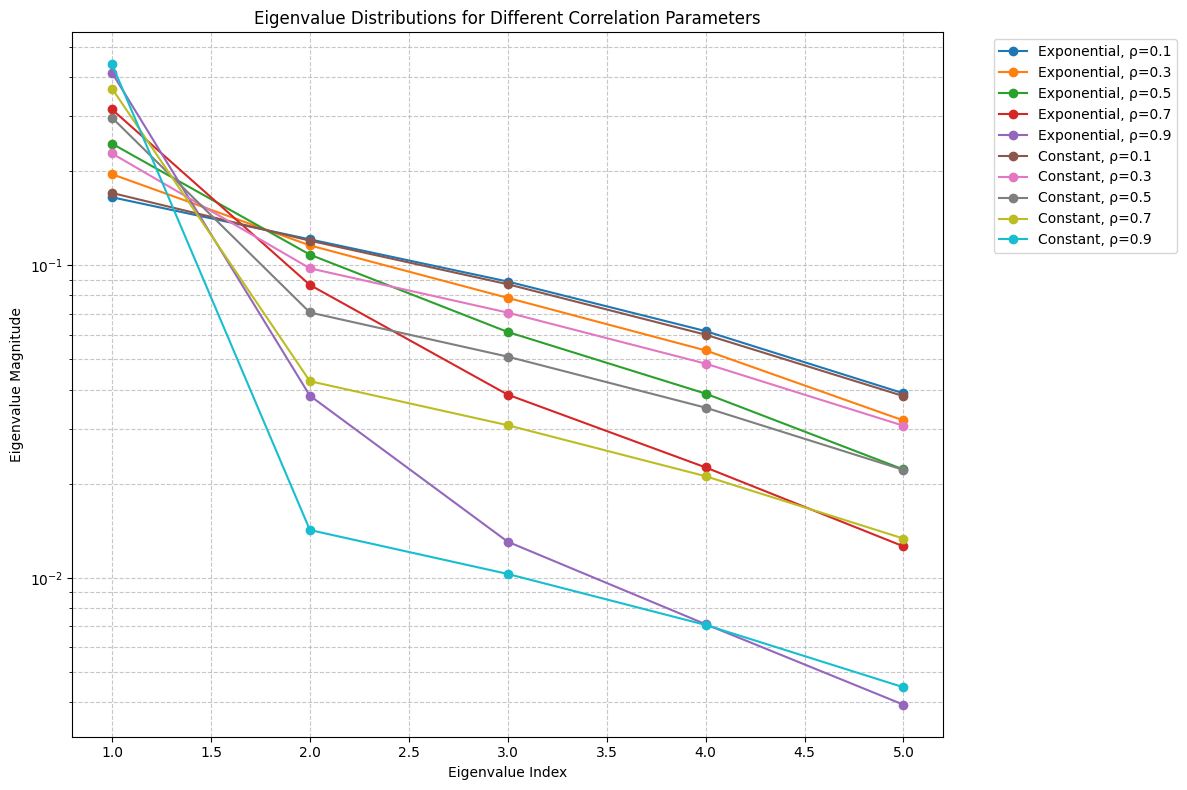

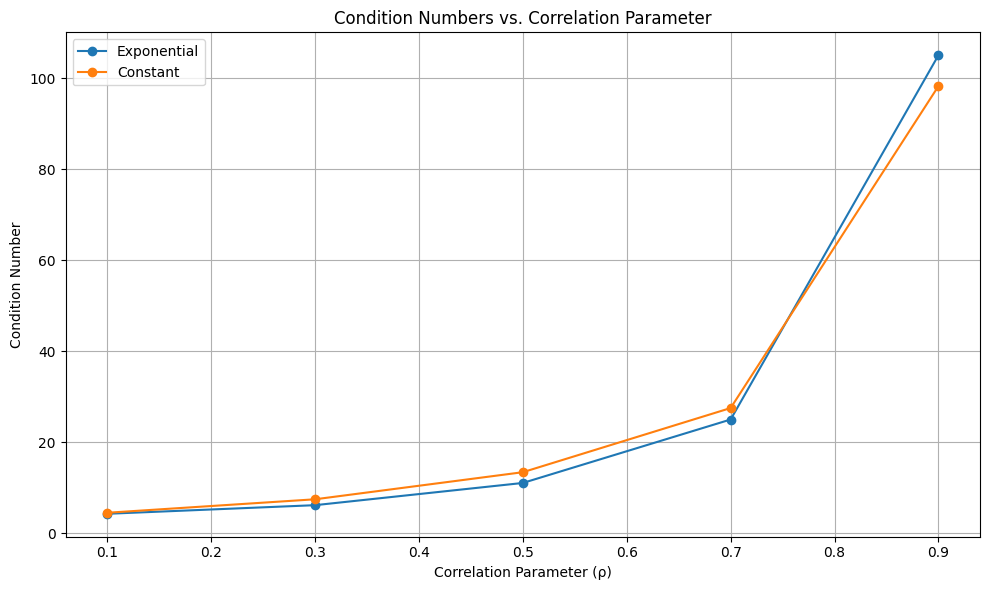

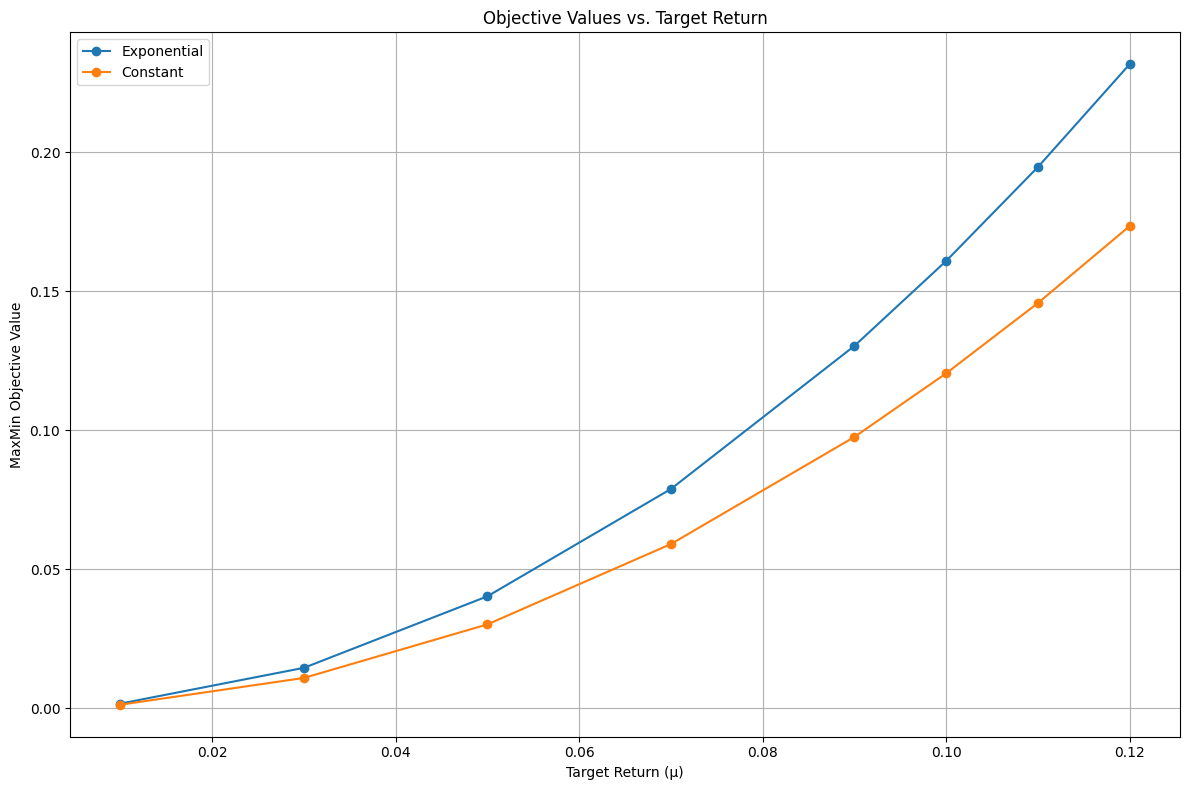

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, linprog
from itertools import combinations
from functools import lru_cache
import os
from datetime import datetime

# ================================================================
# 1. Core Mathematical Functions
# ================================================================
def generate_exponential_correlation(n, rho):
    """
    Generate Toeplitz correlation matrix with exponential decay.

    Rᵢⱼ = ρ^|i-j| creates a stationary correlation structure commonly
    used in time series analysis and risk modeling.
    """
    i, j = np.indices((n, n))
    return rho ** np.abs(i - j)

def generate_constant_correlation(n, rho):
    """
    Generate equicorrelation matrix with constant off-diagonal elements.

    Rᵢⱼ = ρ for all i≠j, and Rᵢᵢ = 1 represents a compound symmetry structure
    with eigenvalues λ₁ = 1+(n-1)ρ and λ₂...ₙ = 1-ρ.
    """
    R = np.ones((n, n)) * rho
    np.fill_diagonal(R, 1.0)
    return R

def correlation_to_covariance(R_corr, sigma):
    """
    Convert correlation matrix to covariance matrix via Σ = DRD.

    Parameters:
      R_corr: Correlation matrix (n×n)
      sigma: Vector of standard deviations (n×1)

    Returns:
      Covariance matrix (n×n)
    """
    D = np.diag(sigma)
    return D @ R_corr @ D

def compute_weighted_covariance(V_list, r_list, w):
    """
    Calculate weighted covariance matrix for robust optimization.

    V^w = Σ w_m V_m - (Σ w_m r_m)(Σ w_m r_m)^T

    Parameters:
      V_list: List of covariance matrices [V₁, V₂, ..., V_M]
      r_list: List of return vectors [r₁, r₂, ..., r_M]
      w: Model weights [w₁, w₂, ..., w_M]

    Returns:
      Weighted covariance matrix V^w
    """
    M = len(V_list)
    n = V_list[0].shape[0]

    # Σ w_m V_m
    V_w = np.zeros((n, n))
    for m in range(M):
        V_w += w[m] * V_list[m]

    # Σ w_m r_m
    r_w = np.zeros(n)
    for m in range(M):
        r_w += w[m] * r_list[m]

    # (Σ w_m r_m)(Σ w_m r_m)^T
    V_w -= np.outer(r_w, r_w)

    return V_w

# ================================================================
# 2. Portfolio Optimization Solvers
# ================================================================
def solve_portfolio_solver(V_w, R, mu, tol=1e-8):
    """
    Solve the mean-variance portfolio problem using SLSQP.

    min π^T V^w π
    s.t. r_m^T π ≥ μ, ∀m ∈ {1,...,M}
    """
    n = V_w.shape[0]

    def objective(pi):
        return pi @ V_w @ pi

    def grad_objective(pi):
        return 2 * V_w @ pi

    # Define inequality constraints: R @ π - μ ≥ 0
    def constraints_fun(pi):
        return R @ pi - mu

    def constraints_jac(pi):
        return R

    constraints = [{
        'type': 'ineq',
        'fun': constraints_fun,
        'jac': constraints_jac
    }]

    # Get initial point using linear programming
    A_ub = -R
    b_ub = -mu * np.ones(R.shape[0])
    bounds = [(None, None)] * n
    res_lp = linprog(c=np.zeros(n), A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
    pi0 = res_lp.x if res_lp.success else np.ones(n)

    sol = minimize(objective, pi0, jac=grad_objective,
                  constraints=constraints, method='SLSQP', tol=tol)
    return sol

# Caching mechanism for inner optimization problem
V_list_global = None
r_list_global = None

@lru_cache(maxsize=1024)
def solve_inner_min_problem_cached(w_tuple, mu, V_list_id, r_list_id):
    """Cached solver for the inner minimization problem."""
    global V_list_global, r_list_global
    w = np.array(w_tuple)

    # Get global variables
    V_list = V_list_global
    r_list = r_list_global

    # Compute weighted covariance matrix
    V_w = compute_weighted_covariance(V_list, r_list, w)

    # Create return matrix
    R_matrix = np.vstack(r_list)

    # Solve inner minimization problem
    sol = solve_portfolio_solver(V_w, R_matrix, mu)

    if sol.success:
        return sol.x, sol.fun, True
    else:
        return None, np.inf, False

def solve_inner_min_problem(V_list, r_list, w, mu):
    """Wrapper for cached inner minimization solver"""
    global V_list_global, r_list_global

    # Save to global variables
    V_list_global = V_list
    r_list_global = r_list

    # Generate IDs
    V_list_id = id(tuple(map(id, V_list)))
    r_list_id = id(tuple(map(id, r_list)))

    return solve_inner_min_problem_cached(tuple(w), mu, V_list_id, r_list_id)

def solve_maxmin_vertices_edges(V_list, r_list, mu):
    """
    Efficiently search vertices and edges of the simplex for MaxMin problem.

    This function implements a geometric approach to solving the maximin problem
    by systematically exploring the simplex structure.
    """
    M = len(V_list)

    # 1. Process all vertices
    vertices = np.eye(M)  # Identity matrix represents vertices of the simplex
    vertex_results = []

    for m, w in enumerate(vertices):
        pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)
        if success:
            vertex_results.append({
                'type': 'vertex',
                'w': w.copy(),
                'pi': pi,
                'obj': obj,
                'success': success,
                'vertex_idx': m
            })

    # 2. Process points along edges
    edge_results = []
    alphas = np.linspace(0.1, 0.9, 9)  # Exploration points along edges

    for i, j in combinations(range(M), 2):
        for alpha in alphas:
            w = np.zeros(M)
            w[i] = alpha
            w[j] = 1 - alpha

            pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)

            if success:
                edge_results.append({
                    'type': 'edge',
                    'w': w.copy(),
                    'pi': pi,
                    'obj': obj,
                    'success': success,
                    'edge': (i, j),
                    'alpha': alpha
                })

    # 3. Combine results and find optimal solution
    results = vertex_results + edge_results

    valid_results = [r for r in results if r['success']]
    if not valid_results:
        return None, None, np.nan, results

    best_result = max(valid_results, key=lambda r: r['obj'])

    return best_result['w'], best_result['pi'], best_result['obj'], results

# ================================================================
# 3. Multi-Correlation Analysis with Fixed Volatility
# ================================================================
def run_multi_correlation_analysis_with_csv(n, rho_list, sigma, r_list, mu_list,
                                           corr_types=['exponential', 'constant'],
                                           export_path='results'):
    """
    Run portfolio optimization across multiple correlation parameters with fixed volatility.

    Parameters:
        n: Number of assets
        rho_list: List of correlation parameters to analyze
        sigma: Fixed standard deviation vector
        r_list: List of return vectors
        mu_list: List of target returns to test
        corr_types: List of correlation types to analyze
        export_path: Directory path for exporting results
    """
    # Ensure results directory exists
    os.makedirs(export_path, exist_ok=True)

    # Timestamp for file naming
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Initialize dataframes for collecting results
    all_results_df = pd.DataFrame()
    eigenvalues_df = pd.DataFrame()
    scenario_risks_df = pd.DataFrame()
    portfolio_weights_df = pd.DataFrame()

    # Number of models equals number of correlation parameters
    M = len(rho_list)

    # Run analysis for each correlation type
    for corr_type in corr_types:
        print(f"\n{'='*80}")
        print(f"PORTFOLIO OPTIMIZATION WITH {M} CORRELATION SCENARIOS")
        print(f"Correlation Type: {corr_type}, Volatility: {sigma}")
        print(f"{'='*80}")

        # Generate covariance matrices for different correlation parameters
        V_list = []
        for i, rho in enumerate(rho_list):
            # Generate correlation matrix based on the type
            if corr_type == 'exponential':
                correlation = generate_exponential_correlation(n, rho)
            else:  # constant
                correlation = generate_constant_correlation(n, rho)

            # Convert to covariance matrix using fixed sigma
            V = correlation_to_covariance(correlation, sigma)
            V_list.append(V)

            # Extract eigenvalues for analysis
            eigvals = np.linalg.eigvals(V).real
            eigvals = np.sort(eigvals)[::-1]
            condition_number = eigvals[0]/eigvals[-1]

            # Add to eigenvalues dataframe
            eig_row = {
                'Correlation_Type': corr_type,
                'Rho': rho,
                'Scenario': i+1
            }

            # Add individual eigenvalues
            for j, val in enumerate(eigvals):
                eig_row[f'Eigenvalue_{j+1}'] = val

            eig_row['Condition_Number'] = condition_number
            eigenvalues_df = pd.concat([eigenvalues_df, pd.DataFrame([eig_row])], ignore_index=True)

            print(f"\nCorrelation Scenario {i+1} - ρ={rho} - Eigenvalues:")
            print(f"  λ₁: {eigvals[0]:.6f}, λ₂: {eigvals[1]:.6f}, ..., λ₅: {eigvals[4]:.6f}")
            print(f"  Condition Number: {condition_number:.2f}")

        # Process each target return
        for mu in mu_list:
            print(f"\n{'-'*70}")
            print(f"Target Return (μ): {mu}")

            # Find MaxMin optimal portfolio
            ve_w_opt, ve_pi_opt, ve_obj_val, ve_results = solve_maxmin_vertices_edges(
                V_list, r_list[:M], mu)

            if ve_w_opt is not None:
                print(f"Optimal Model Weights (w*): {ve_w_opt}")
                print(f"Optimal Portfolio (π*): {ve_pi_opt}")
                print(f"Objective Value (MaxMin): {ve_obj_val:.6f}")

                # Check return constraints
                returns = np.array([r @ ve_pi_opt for r in r_list[:M]])
                for i, ret in enumerate(returns):
                    print(f"Model {i+1} Return (ρ={rho_list[i]}): {ret:.6f} (≥ {mu})")

                # Determine optimal location (vertex or edge)
                best_result = max([r for r in ve_results if r['success']],
                                  key=lambda r: r['obj'])

                if best_result['type'] == 'vertex':
                    model_idx = np.argmax(best_result['w'])
                    location = f"Vertex (ρ={rho_list[model_idx]})"
                else:  # edge
                    i, j = best_result['edge']
                    alpha = best_result['alpha']
                    location = f"Edge (ρ={rho_list[i]}-ρ={rho_list[j]}, α={alpha:.2f})"

                print(f"Optimal Location: {location}")

                # Calculate portfolio risk under each correlation scenario
                risks = []
                for i, V in enumerate(V_list):
                    risk = np.sqrt(ve_pi_opt @ V @ ve_pi_opt)
                    risks.append(risk)
                    print(f"Portfolio Risk (Correlation ρ={rho_list[i]}): {risk:.6f}")

                # Add main result to dataframe
                result_row = {
                    'Correlation_Type': corr_type,
                    'Target_Return': mu,
                    'Objective_Value': ve_obj_val,
                    'Optimal_Location': location
                }

                # Add to all results dataframe
                all_results_df = pd.concat([all_results_df, pd.DataFrame([result_row])], ignore_index=True)

                # Add scenario risks to risks dataframe
                risk_row = {
                    'Correlation_Type': corr_type,
                    'Target_Return': mu
                }

                for i, risk in enumerate(risks):
                    risk_row[f'Risk_Rho_{rho_list[i]}'] = risk

                scenario_risks_df = pd.concat([scenario_risks_df, pd.DataFrame([risk_row])], ignore_index=True)

                # Add portfolio weights to weights dataframe
                weight_row = {
                    'Correlation_Type': corr_type,
                    'Target_Return': mu
                }

                # Add model weights
                for i in range(M):
                    weight_row[f'Weight_Rho_{rho_list[i]}'] = ve_w_opt[i]

                # Add portfolio weights
                for i in range(n):
                    weight_row[f'Portfolio_Weight_{i+1}'] = ve_pi_opt[i]

                portfolio_weights_df = pd.concat([portfolio_weights_df, pd.DataFrame([weight_row])], ignore_index=True)
            else:
                print("No valid solution found.")

    # Export all dataframes to CSV
    all_results_df.to_csv(f"{export_path}/all_results_{timestamp}.csv", index=False)
    eigenvalues_df.to_csv(f"{export_path}/eigenvalues_{timestamp}.csv", index=False)
    scenario_risks_df.to_csv(f"{export_path}/scenario_risks_{timestamp}.csv", index=False)
    portfolio_weights_df.to_csv(f"{export_path}/portfolio_weights_{timestamp}.csv", index=False)

    # Create a pivot table for cross-correlation comparison
    pivot_df = all_results_df.pivot_table(
        index=['Target_Return'],
        columns=['Correlation_Type'],
        values='Objective_Value',
        aggfunc='first'
    ).reset_index()

    pivot_df.to_csv(f"{export_path}/corr_comparison_{timestamp}.csv")

    print(f"\nResults exported to CSV files in '{export_path}' directory:")
    print(f"  - all_results_{timestamp}.csv")
    print(f"  - eigenvalues_{timestamp}.csv")
    print(f"  - scenario_risks_{timestamp}.csv")
    print(f"  - portfolio_weights_{timestamp}.csv")
    print(f"  - corr_comparison_{timestamp}.csv")

    return {
        'all_results': all_results_df,
        'eigenvalues': eigenvalues_df,
        'scenario_risks': scenario_risks_df,
        'portfolio_weights': portfolio_weights_df,
        'cross_corr_comparison': pivot_df
    }

# ================================================================
# 4. Main Execution Function
# ================================================================
def main_multi_correlation_analysis():
    """Execute portfolio optimization with multiple correlation parameters."""
    # Asset count
    n = 5

    # Multiple correlation parameters
    rho_list = [0.1, 0.3, 0.5, 0.7, 0.9]

    # Fixed volatility scenario
    sigma = np.array([0.20, 0.25, 0.30, 0.35, 0.40])

    # Return vectors (define 5 to match number of correlation parameters)
    r_list = [
        np.array([0.02, 0.04, 0.06, 0.08, 0.10]),        # Return vector 1
        np.array([0.01, 0.03, 0.05, 0.07, 0.09]),        # Return vector 2
        np.array([0.015, 0.035, 0.055, 0.075, 0.095]),   # Return vector 3
        np.array([0.025, 0.045, 0.065, 0.085, 0.105]),   # Return vector 4
        np.array([0.018, 0.038, 0.058, 0.078, 0.098])    # Return vector 5
    ]

    # Target returns
    mu_list = [0.01, 0.03, 0.05, 0.07, 0.09,0.10,0.11,0.12]

    # Run analysis and export results
    results = run_multi_correlation_analysis_with_csv(
        n, rho_list, sigma, r_list, mu_list,
        corr_types=['exponential', 'constant'],
        export_path='correlation_results'
    )

    # Generate additional visualizations

    # 1. Plot eigenvalue distributions for different correlation parameters
    plt.figure(figsize=(12, 8))
    for corr_type in ['exponential', 'constant']:
        eigvals_subset = results['eigenvalues'][results['eigenvalues']['Correlation_Type'] == corr_type]

        for rho in rho_list:
            row = eigvals_subset[eigvals_subset['Rho'] == rho].iloc[0]
            eigenvalues = [row[f'Eigenvalue_{i+1}'] for i in range(n)]
            plt.plot(range(1, n+1), eigenvalues, marker='o', label=f"{corr_type.capitalize()}, ρ={rho}")

    plt.title('Eigenvalue Distributions for Different Correlation Parameters')
    plt.xlabel('Eigenvalue Index')
    plt.ylabel('Eigenvalue Magnitude')
    plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"correlation_results/eigenvalue_distributions.png")

    # 2. Plot condition numbers
    plt.figure(figsize=(10, 6))
    for corr_type in ['exponential', 'constant']:
        eigvals_subset = results['eigenvalues'][results['eigenvalues']['Correlation_Type'] == corr_type]
        rhos = eigvals_subset['Rho'].values
        condition_numbers = eigvals_subset['Condition_Number'].values

        plt.plot(rhos, condition_numbers, marker='o', label=corr_type.capitalize())

    plt.title('Condition Numbers vs. Correlation Parameter')
    plt.xlabel('Correlation Parameter (ρ)')
    plt.ylabel('Condition Number')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"correlation_results/condition_numbers.png")

    # 3. Plot objective values for different target returns
    plt.figure(figsize=(12, 8))
    for corr_type in ['exponential', 'constant']:
        results_subset = results['all_results'][results['all_results']['Correlation_Type'] == corr_type]
        target_returns = sorted(results_subset['Target_Return'].unique())
        obj_values = [results_subset[results_subset['Target_Return'] == mu]['Objective_Value'].values[0]
                     for mu in target_returns]

        plt.plot(target_returns, obj_values, marker='o', label=corr_type.capitalize())

    plt.title('Objective Values vs. Target Return')
    plt.xlabel('Target Return (μ)')
    plt.ylabel('MaxMin Objective Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"correlation_results/objective_values.png")

    return results

# ================================================================
# 5. Execute if run directly
# ================================================================
if __name__ == "__main__":
    results = main_multi_correlation_analysis()

以下の企業の株価を取得し，分析を行う．

- **AAPL**: Apple Inc.（アップル）  
- **AMZN**: Amazon.com, Inc.（アマゾン）  
- **BRK-B**: Berkshire Hathaway Inc.（バークシャー・ハサウェイ、クラスB株）  
- **GOOG**: Alphabet Inc.（アルファベット、Googleの親会社）  
- **JNJ**: Johnson & Johnson（ジョンソン・エンド・ジョンソン）  
- **JPM**: JPMorgan Chase & Co.（JPモルガン・チェース）  
- **MA**: Mastercard Incorporated（マスターカード）  
- **MSFT**: Microsoft Corporation（マイクロソフト）  
- **PG**: Procter & Gamble Company（プロクター・アンド・ギャンブル）  
- **V**: Visa Inc.（ビザ）

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize, linprog
import os
from datetime import datetime
import yfinance as yf
from itertools import combinations
from functools import lru_cache

# ================================================================
# 1. データ取得・処理機能
# ================================================================

def load_price_data(file_path=None, tickers=None, start_date=None, end_date=None, source='csv'):
    """
    株価データを読み込む関数

    Parameters:
    -----------
    file_path : str, optional
        CSVファイルのパス (source='csv'の場合)
    tickers : list, optional
        銘柄コードのリスト (source='yfinance'の場合)
    start_date : str, optional
        開始日 (YYYY-MM-DD形式) (source='yfinance'の場合)
    end_date : str, optional
        終了日 (YYYY-MM-DD形式) (source='yfinance'の場合)
    source : str, default 'csv'
        データソース ('csv' または 'yfinance')

    Returns:
    --------
    prices : pandas.DataFrame
        株価データのデータフレーム (インデックスは日付)
    """
    if source == 'csv':
        if file_path is None:
            raise ValueError("CSVファイルのパスを指定してください")

        # CSVからデータを読み込む
        prices = pd.read_csv(file_path)

        # 日付カラムをインデックスに設定
        date_col = None
        for col in prices.columns:
            if 'date' in col.lower() or 'time' in col.lower():
                date_col = col
                break

        if date_col:
            prices[date_col] = pd.to_datetime(prices[date_col])
            prices.set_index(date_col, inplace=True)

    elif source == 'yfinance':
        if tickers is None or start_date is None or end_date is None:
            raise ValueError("tickers, start_date, end_dateを指定してください")

        # Yahoo Financeからデータを取得 - auto_adjust=Trueがデフォルト（調整済み株価のみ返す）
        prices = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)

        # 終値のみを抽出（auto_adjust=Trueの場合、'Close'が調整済み株価）
        if isinstance(prices.columns, pd.MultiIndex):
            prices = prices['Close']
    else:
        raise ValueError("sourceは'csv'または'yfinance'を指定してください")

    return prices

def calculate_returns(prices, method='log', period='daily'):
    """
    リターンを計算する関数

    Parameters:
    -----------
    prices : pandas.DataFrame
        株価データのデータフレーム
    method : str, default 'log'
        リターン計算方法 ('log'=対数リターン, 'simple'=単純リターン)
    period : str, default 'daily'
        期間指定 ('daily'=日次, 'weekly'=週次, 'monthly'=月次, 'annual'=年次)

    Returns:
    --------
    returns : pandas.DataFrame
        リターンのデータフレーム
    """
    # 期間でリサンプリング
    if period == 'daily':
        resampled_prices = prices
    elif period == 'weekly':
        resampled_prices = prices.resample('W').last()
    elif period == 'monthly':
        resampled_prices = prices.resample('M').last()
    elif period == 'annual':
        resampled_prices = prices.resample('Y').last()
    else:
        raise ValueError("periodは'daily', 'weekly', 'monthly', 'annual'のいずれかを指定してください")

    # リターン計算
    if method == 'log':
        # 対数リターン: log(P_t/P_{t-1})
        returns = np.log(resampled_prices / resampled_prices.shift(1))
    elif method == 'simple':
        # 単純リターン: (P_t/P_{t-1}) - 1
        returns = resampled_prices.pct_change()
    else:
        raise ValueError("methodは'log'または'simple'を指定してください")

    # 最初の行（NaN）を削除
    returns = returns.dropna()

    return returns

# ================================================================
# 2. 統計分析機能
# ================================================================

def calculate_statistics(returns, period='daily', annualization_factor=None):
    """
    リターンの統計量を計算する関数

    Parameters:
    -----------
    returns : pandas.DataFrame
        リターンのデータフレーム
    period : str, default 'daily'
        期間指定 ('daily'=日次, 'weekly'=週次, 'monthly'=月次, 'annual'=年次)
    annualization_factor : int, optional
        年率化係数 (指定しない場合は自動計算)

    Returns:
    --------
    stats : pandas.DataFrame
        統計量のデータフレーム
    """
    # デフォルトの年率化係数
    if annualization_factor is None:
        if period == 'daily':
            annualization_factor = 252
        elif period == 'weekly':
            annualization_factor = 52
        elif period == 'monthly':
            annualization_factor = 12
        elif period == 'annual':
            annualization_factor = 1

    # 統計量の計算
    mean_return = returns.mean()
    median_return = returns.median()
    std_return = returns.std()
    min_return = returns.min()
    max_return = returns.max()
    skewness = returns.skew()
    kurtosis = returns.kurtosis()

    # 年率化リターンと標準偏差
    annual_return = mean_return * annualization_factor
    annual_std = std_return * np.sqrt(annualization_factor)

    # シャープレシオ (無リスク金利を0%と仮定)
    sharpe_ratio = annual_return / annual_std

    # 統計量のデータフレーム
    stats = pd.DataFrame({
        'Mean Return': mean_return,
        'Median Return': median_return,
        'Std Dev': std_return,
        'Min Return': min_return,
        'Max Return': max_return,
        'Skewness': skewness,
        'Kurtosis': kurtosis,
        'Annual Return': annual_return,
        'Annual Std Dev': annual_std,
        'Sharpe Ratio': sharpe_ratio
    })

    return stats

def calculate_covariance_matrix(returns, period='daily', annualization_factor=None):
    """
    共分散行列を計算する関数

    Parameters:
    -----------
    returns : pandas.DataFrame
        リターンのデータフレーム
    period : str, default 'daily'
        期間指定 ('daily'=日次, 'weekly'=週次, 'monthly'=月次, 'annual'=年次)
    annualization_factor : int, optional
        年率化係数 (指定しない場合は自動計算)

    Returns:
    --------
    cov_matrix : pandas.DataFrame
        共分散行列
    corr_matrix : pandas.DataFrame
        相関行列
    """
    # デフォルトの年率化係数
    if annualization_factor is None:
        if period == 'daily':
            annualization_factor = 252
        elif period == 'weekly':
            annualization_factor = 52
        elif period == 'monthly':
            annualization_factor = 12
        elif period == 'annual':
            annualization_factor = 1

    # 共分散行列と相関行列を計算
    cov_matrix = returns.cov() * annualization_factor
    corr_matrix = returns.corr()

    return cov_matrix, corr_matrix

# ================================================================
# 3. 共分散モデリングと相関構造
# ================================================================

def generate_exponential_correlation(n, rho):
    """
    指数減衰型のToeplitz相関行列を生成

    Rᵢⱼ = ρ^|i-j|

    Parameters:
    -----------
    n : int
        相関行列の次元数
    rho : float
        相関パラメータ (0 ≤ ρ < 1)

    Returns:
    --------
    R : numpy.ndarray
        n×n の指数減衰相関行列
    """
    i, j = np.indices((n, n))
    return rho ** np.abs(i - j)

def generate_constant_correlation(n, rho):
    """
    等相関行列（Equicorrelation matrix）を生成

    Rᵢⱼ = ρ (i≠j)
    Rᵢᵢ = 1

    Parameters:
    -----------
    n : int
        相関行列の次元数
    rho : float
        相関パラメータ (-1/(n-1) < ρ < 1)

    Returns:
    --------
    R : numpy.ndarray
        n×n の等相関行列
    """
    R = np.ones((n, n)) * rho
    np.fill_diagonal(R, 1.0)
    return R

def correlation_to_covariance(R_corr, sigma):
    """
    相関行列を共分散行列に変換: Σ = DRD

    Parameters:
    -----------
    R_corr : numpy.ndarray
        相関行列 (n×n)
    sigma : numpy.ndarray
        標準偏差ベクトル (n×1)

    Returns:
    --------
    Sigma : numpy.ndarray
        共分散行列 (n×n)
    """
    D = np.diag(sigma)
    return D @ R_corr @ D

def compute_weighted_covariance(V_list, r_list, w):
    """
    頑健最適化のための加重共分散行列を計算

    V^w = Σ w_m V_m - (Σ w_m r_m)(Σ w_m r_m)^T

    Parameters:
    -----------
    V_list : list
        共分散行列のリスト [V₁, V₂, ..., V_M]
    r_list : list
        期待リターンベクトルのリスト [r₁, r₂, ..., r_M]
    w : numpy.ndarray
        モデル重みベクトル [w₁, w₂, ..., w_M]

    Returns:
    --------
    V_w : numpy.ndarray
        加重共分散行列 V^w
    """
    M = len(V_list)
    n = V_list[0].shape[0]

    # Σ w_m V_m
    V_w = np.zeros((n, n))
    for m in range(M):
        V_w += w[m] * V_list[m]

    # Σ w_m r_m
    r_w = np.zeros(n)
    for m in range(M):
        r_w += w[m] * r_list[m]

    # (Σ w_m r_m)(Σ w_m r_m)^T
    V_w -= np.outer(r_w, r_w)

    return V_w

# ================================================================
# 4. ポートフォリオ最適化ソルバー
# ================================================================

def solve_portfolio_solver(V_w, R, mu, tol=1e-8):
    """
    SLSQPを用いた平均分散ポートフォリオ問題の解法

    min π^T V^w π
    s.t. r_m^T π ≥ μ, ∀m ∈ {1,...,M}

    Parameters:
    -----------
    V_w : numpy.ndarray
        加重共分散行列
    R : numpy.ndarray
        各モデルの期待リターン行列
    mu : float
        目標リターン閾値
    tol : float, default 1e-8
        最適化収束許容誤差

    Returns:
    --------
    sol : OptimizeResult
        最適化結果オブジェクト
    """
    n = V_w.shape[0]

    def objective(pi):
        return pi @ V_w @ pi

    def grad_objective(pi):
        return 2 * V_w @ pi

    # 不等式制約の定義: R @ π - μ ≥ 0
    def constraints_fun(pi):
        return R @ pi - mu

    def constraints_jac(pi):
        return R

    constraints = [{
        'type': 'ineq',
        'fun': constraints_fun,
        'jac': constraints_jac
    }]

    # 線形計画法による初期点の取得
    A_ub = -R
    b_ub = -mu * np.ones(R.shape[0])
    bounds = [(None, None)] * n
    res_lp = linprog(c=np.zeros(n), A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
    pi0 = res_lp.x if res_lp.success else np.ones(n)

    sol = minimize(objective, pi0, jac=grad_objective,
                  constraints=constraints, method='SLSQP', tol=tol)
    return sol

# 内部最適化問題のキャッシュメカニズム
V_list_global = None
r_list_global = None

@lru_cache(maxsize=1024)
def solve_inner_min_problem_cached(w_tuple, mu, V_list_id, r_list_id):
    """
    内部最小化問題のキャッシュソルバー

    Parameters:
    -----------
    w_tuple : tuple
        モデル重みのタプル
    mu : float
        目標リターン閾値
    V_list_id, r_list_id : id
        V_listとr_listのオブジェクトID

    Returns:
    --------
    pi : numpy.ndarray or None
        最適ポートフォリオ配分
    obj : float
        目的関数値
    success : bool
        最適化成功フラグ
    """
    global V_list_global, r_list_global
    w = np.array(w_tuple)

    # グローバル変数の取得
    V_list = V_list_global
    r_list = r_list_global

    # 加重共分散行列の計算
    V_w = compute_weighted_covariance(V_list, r_list, w)

    # リターン行列の作成
    R_matrix = np.vstack(r_list)

    # 内部最小化問題の解法
    sol = solve_portfolio_solver(V_w, R_matrix, mu)

    if sol.success:
        return sol.x, sol.fun, True
    else:
        return None, np.inf, False

def solve_inner_min_problem(V_list, r_list, w, mu):
    """
    キャッシュ付き内部最小化ソルバーのラッパー

    Parameters:
    -----------
    V_list : list
        共分散行列のリスト
    r_list : list
        期待リターンベクトルのリスト
    w : numpy.ndarray
        モデル重みベクトル
    mu : float
        目標リターン閾値

    Returns:
    --------
    pi, obj, success : tuple
        最適化結果
    """
    global V_list_global, r_list_global

    # グローバル変数への保存
    V_list_global = V_list
    r_list_global = r_list

    # IDの生成
    V_list_id = id(tuple(map(id, V_list)))
    r_list_id = id(tuple(map(id, r_list)))

    return solve_inner_min_problem_cached(tuple(w), mu, V_list_id, r_list_id)

def solve_maxmin_vertices_edges(V_list, r_list, mu):
    """
    単体（シンプレックス）の頂点と辺の探索による頑健なMaxMin問題の解法

    Parameters:
    -----------
    V_list : list
        共分散行列のリスト
    r_list : list
        期待リターンベクトルのリスト
    mu : float
        目標リターン閾値

    Returns:
    --------
    w_opt : numpy.ndarray
        最適モデル重み
    pi_opt : numpy.ndarray
        最適ポートフォリオ配分
    obj_val : float
        目的関数値
    results : list
        詳細結果リスト
    """
    M = len(V_list)

    # 1. すべての頂点を処理
    vertices = np.eye(M)  # 単位行列は単体の頂点を表す
    vertex_results = []

    for m, w in enumerate(vertices):
        pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)
        if success:
            vertex_results.append({
                'type': 'vertex',
                'w': w.copy(),
                'pi': pi,
                'obj': obj,
                'success': success,
                'vertex_idx': m
            })

    # 2. 辺上の点を処理
    edge_results = []
    alphas = np.linspace(0.1, 0.9, 9)  # 辺上の探索点

    for i, j in combinations(range(M), 2):
        for alpha in alphas:
            w = np.zeros(M)
            w[i] = alpha
            w[j] = 1 - alpha

            pi, obj, success = solve_inner_min_problem(V_list, r_list, w, mu)

            if success:
                edge_results.append({
                    'type': 'edge',
                    'w': w.copy(),
                    'pi': pi,
                    'obj': obj,
                    'success': success,
                    'edge': (i, j),
                    'alpha': alpha
                })

    # 3. 結果を結合して最適解を探索
    results = vertex_results + edge_results

    valid_results = [r for r in results if r['success']]
    if not valid_results:
        return None, None, np.nan, results

    best_result = max(valid_results, key=lambda r: r['obj'])

    return best_result['w'], best_result['pi'], best_result['obj'], results

# ================================================================
# 5. 可視化・分析機能
# ================================================================

def plot_prices_and_returns(prices, returns, asset_name=None, output_dir=None):
    """
    価格とリターンをプロットする関数

    Parameters:
    -----------
    prices : pandas.DataFrame or pandas.Series
        価格データ
    returns : pandas.DataFrame or pandas.Series
        リターンデータ
    asset_name : str, optional
        資産名 (指定しない場合はすべての資産をプロット)
    output_dir : str, optional
        出力ディレクトリ (指定しない場合は保存しない)
    """
    if asset_name is not None:
        if asset_name in prices.columns:
            price_data = prices[asset_name]
            return_data = returns[asset_name]
            title_suffix = f" - {asset_name}"
        else:
            raise ValueError(f"{asset_name}はデータに存在しません")
    else:
        price_data = prices
        return_data = returns
        title_suffix = ""

    # 価格のプロット
    plt.figure(figsize=(12, 6))
    if isinstance(price_data, pd.DataFrame):
        for col in price_data.columns:
            plt.plot(price_data.index, price_data[col], label=col)
        plt.legend()
    else:
        plt.plot(price_data.index, price_data)
    plt.title(f"価格チャート{title_suffix}")
    plt.xlabel("日付")
    plt.ylabel("価格")
    plt.grid(True)

    if output_dir:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        if asset_name:
            plt.savefig(os.path.join(output_dir, f"price_{asset_name}.png"), dpi=300, bbox_inches='tight')
        else:
            plt.savefig(os.path.join(output_dir, "price_all.png"), dpi=300, bbox_inches='tight')

    plt.show()

    # リターンのプロット
    plt.figure(figsize=(12, 6))
    if isinstance(return_data, pd.DataFrame):
        for col in return_data.columns:
            plt.plot(return_data.index, return_data[col], label=col, alpha=0.7)
        plt.legend()
    else:
        plt.plot(return_data.index, return_data)
    plt.title(f"リターンチャート{title_suffix}")
    plt.xlabel("日付")
    plt.ylabel("リターン")
    plt.grid(True)

    if output_dir:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        if asset_name:
            plt.savefig(os.path.join(output_dir, f"return_{asset_name}.png"), dpi=300, bbox_inches='tight')
        else:
            plt.savefig(os.path.join(output_dir, "return_all.png"), dpi=300, bbox_inches='tight')

    plt.show()

    # ヒストグラムのプロット
    plt.figure(figsize=(12, 6))
    if isinstance(return_data, pd.DataFrame):
        for col in return_data.columns:
            plt.hist(return_data[col].dropna(), bins=50, alpha=0.5, label=col)
        plt.legend()
    else:
        plt.hist(return_data.dropna(), bins=50)
    plt.title(f"リターン分布{title_suffix}")
    plt.xlabel("リターン")
    plt.ylabel("頻度")
    plt.grid(True)

    if output_dir:
        if asset_name:
            plt.savefig(os.path.join(output_dir, f"histogram_{asset_name}.png"), dpi=300, bbox_inches='tight')
        else:
            plt.savefig(os.path.join(output_dir, "histogram_all.png"), dpi=300, bbox_inches='tight')

    plt.show()

def plot_correlation_matrix(corr_matrix, output_dir=None):
    """
    相関行列をヒートマップでプロットする関数

    Parameters:
    -----------
    corr_matrix : pandas.DataFrame
        相関行列
    output_dir : str, optional
        出力ディレクトリ (指定しない場合は保存しない)
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title("相関行列")

    if output_dir:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        plt.savefig(os.path.join(output_dir, "correlation_matrix.png"), dpi=300, bbox_inches='tight')

    plt.show()

# ================================================================
# 6. 統合型頑健ポートフォリオ分析
# ================================================================

def run_multi_correlation_analysis(returns, mu_list, rho_list,
                                   corr_types=['exponential', 'constant'],
                                   output_dir='results'):
    """
    実証データを用いた複数の相関パラメータでのポートフォリオ最適化実行

    Parameters:
    -----------
    returns : pandas.DataFrame
        リターンデータ
    mu_list : list
        検証する目標リターンのリスト
    rho_list : list
        分析する相関パラメータのリスト
    corr_types : list, default ['exponential', 'constant']
        分析する相関タイプのリスト
    output_dir : str, default 'results'
        結果のエクスポート先ディレクトリ

    Returns:
    --------
    results : dict
        すべての結果を含む辞書
    """
    # 資産数
    n = returns.shape[1]

    # 資産名の取得
    asset_names = returns.columns.tolist()

    # 実証統計量の計算
    empirical_mean = returns.mean() * 252  # 年率化
    empirical_std = returns.std() * np.sqrt(252)  # 年率化
    empirical_cov, empirical_corr = calculate_covariance_matrix(returns)

    # NumPy配列への変換
    sigma = empirical_std.values

    # リターンベクトルの生成（相関シナリオごとに1つ）
    r_list = []
    for i in range(len(rho_list)):
        # 実証平均に微小な摂動を加えたバージョンを作成
        perturbation = np.random.normal(0, 0.005, n)
        r_list.append(empirical_mean.values + perturbation)

    # 結果ディレクトリの確保
    os.makedirs(output_dir, exist_ok=True)

    # タイムスタンプ（ファイル命名用）
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # 結果収集用データフレームの初期化
    all_results_df = pd.DataFrame()
    eigenvalues_df = pd.DataFrame()
    scenario_risks_df = pd.DataFrame()
    portfolio_weights_df = pd.DataFrame()

    # モデル数＝相関パラメータの数
    M = len(rho_list)

    # 各相関タイプの分析実行
    for corr_type in corr_types:
        print(f"\n{'='*80}")
        print(f"{M}個の相関シナリオによるポートフォリオ最適化")
        print(f"相関タイプ: {corr_type}, 実証ボラティリティ: {sigma}")
        print(f"{'='*80}")

        # 異なる相関パラメータに対する共分散行列の生成
        V_list = []
        for i, rho in enumerate(rho_list):
            # タイプに基づく相関行列の生成
            if corr_type == 'exponential':
                correlation = generate_exponential_correlation(n, rho)
            else:  # constant
                correlation = generate_constant_correlation(n, rho)

            # 実証シグマを用いて相関行列を共分散行列に変換
            V = correlation_to_covariance(correlation, sigma)
            V_list.append(V)

            # 分析のための固有値抽出
            eigvals = np.linalg.eigvals(V).real
            eigvals = np.sort(eigvals)[::-1]
            condition_number = eigvals[0]/eigvals[-1]

            # 固有値データフレームに追加
            eig_row = {
                'Correlation_Type': corr_type,
                'Rho': rho,
                'Scenario': i+1
            }

            # 個別固有値の追加
            for j, val in enumerate(eigvals):
                eig_row[f'Eigenvalue_{j+1}'] = val

            eig_row['Condition_Number'] = condition_number
            eigenvalues_df = pd.concat([eigenvalues_df, pd.DataFrame([eig_row])], ignore_index=True)

            # 固有値表示の修正箇所
            print(f"\n相関シナリオ {i+1} - ρ={rho} - 固有値:")
            # 条件分岐を事前に評価して文字列を構築
            if len(eigvals) > 4:
                fifth_eigenvalue = f"{eigvals[4]:.6f}"
            else:
                fifth_eigenvalue = "N/A"
            print(f"  λ₁: {eigvals[0]:.6f}, λ₂: {eigvals[1]:.6f}, ..., λ₅: {fifth_eigenvalue}")
            print(f"  条件数: {condition_number:.2f}")

        # 各目標リターンの処理
        for mu in mu_list:
            print(f"\n{'-'*70}")
            print(f"目標リターン (μ): {mu}")

            # MaxMin最適ポートフォリオの探索
            ve_w_opt, ve_pi_opt, ve_obj_val, ve_results = solve_maxmin_vertices_edges(
                V_list, r_list[:M], mu)

            if ve_w_opt is not None:
                print(f"最適モデル重み (w*): {ve_w_opt}")
                print(f"最適ポートフォリオ (π*): {ve_pi_opt}")
                print(f"目的関数値 (MaxMin): {ve_obj_val:.6f}")

                # リターン制約の確認
                returns_analysis = np.array([r @ ve_pi_opt for r in r_list[:M]])
                for i, ret in enumerate(returns_analysis):
                    print(f"モデル {i+1} リターン (ρ={rho_list[i]}): {ret:.6f} (≥ {mu})")

                # 最適位置の判定（頂点または辺）
                best_result = max([r for r in ve_results if r['success']],
                                  key=lambda r: r['obj'])

                if best_result['type'] == 'vertex':
                    model_idx = np.argmax(best_result['w'])
                    location = f"頂点 (ρ={rho_list[model_idx]})"
                else:  # edge
                    i, j = best_result['edge']
                    alpha = best_result['alpha']
                    location = f"辺 (ρ={rho_list[i]}-ρ={rho_list[j]}, α={alpha:.2f})"

                print(f"最適位置: {location}")

                # 各相関シナリオにおけるポートフォリオリスク計算
                risks = []
                for i, V in enumerate(V_list):
                    risk = np.sqrt(ve_pi_opt @ V @ ve_pi_opt)
                    risks.append(risk)
                    print(f"ポートフォリオリスク (相関 ρ={rho_list[i]}): {risk:.6f}")

                # メイン結果をデータフレームに追加
                result_row = {
                    'Correlation_Type': corr_type,
                    'Target_Return': mu,
                    'Objective_Value': ve_obj_val,
                    'Optimal_Location': location
                }

                # 全結果データフレームに追加
                all_results_df = pd.concat([all_results_df, pd.DataFrame([result_row])], ignore_index=True)

                # シナリオリスクをリスクデータフレームに追加
                risk_row = {
                    'Correlation_Type': corr_type,
                    'Target_Return': mu
                }

                for i, risk in enumerate(risks):
                    risk_row[f'Risk_Rho_{rho_list[i]}'] = risk

                scenario_risks_df = pd.concat([scenario_risks_df, pd.DataFrame([risk_row])], ignore_index=True)

                # ポートフォリオ重みをウェイトデータフレームに追加
                weight_row = {
                    'Correlation_Type': corr_type,
                    'Target_Return': mu
                }

                # モデル重みの追加
                for i in range(M):
                    weight_row[f'Weight_Rho_{rho_list[i]}'] = ve_w_opt[i]

                # ポートフォリオ重みの追加
                for i in range(n):
                    weight_row[f'Portfolio_Weight_{i+1}'] = ve_pi_opt[i]
                    asset_name = asset_names[i] if i < len(asset_names) else f"Asset_{i+1}"
                    weight_row[f'Portfolio_Weight_{asset_name}'] = ve_pi_opt[i]

                portfolio_weights_df = pd.concat([portfolio_weights_df, pd.DataFrame([weight_row])], ignore_index=True)
            else:
                print("有効な解が見つかりません。")

    # すべてのデータフレームをCSVにエクスポート
    all_results_df.to_csv(f"{output_dir}/all_results_{timestamp}.csv", index=False)
    eigenvalues_df.to_csv(f"{output_dir}/eigenvalues_{timestamp}.csv", index=False)
    scenario_risks_df.to_csv(f"{output_dir}/scenario_risks_{timestamp}.csv", index=False)
    portfolio_weights_df.to_csv(f"{output_dir}/portfolio_weights_{timestamp}.csv", index=False)

    # 相関比較用のピボットテーブルを作成
    pivot_df = all_results_df.pivot_table(
        index=['Target_Return'],
        columns=['Correlation_Type'],
        values='Objective_Value',
        aggfunc='first'
    ).reset_index()

    pivot_df.to_csv(f"{output_dir}/corr_comparison_{timestamp}.csv")

    print(f"\n結果が'{output_dir}'ディレクトリのCSVファイルにエクスポートされました:")
    print(f"  - all_results_{timestamp}.csv")
    print(f"  - eigenvalues_{timestamp}.csv")
    print(f"  - scenario_risks_{timestamp}.csv")
    print(f"  - portfolio_weights_{timestamp}.csv")
    print(f"  - corr_comparison_{timestamp}.csv")

    # 追加の可視化

    # 1. 異なる相関パラメータの固有値分布のプロット
    plt.figure(figsize=(12, 8))
    for corr_type in corr_types:
        eigvals_subset = eigenvalues_df[eigenvalues_df['Correlation_Type'] == corr_type]

        for rho in rho_list:
            row = eigvals_subset[eigvals_subset['Rho'] == rho].iloc[0]
            eigenvalue_cols = [col for col in row.index if col.startswith('Eigenvalue_')]
            eigenvalues = [row[col] for col in eigenvalue_cols]
            plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o', label=f"{corr_type.capitalize()}, ρ={rho}")

    plt.title('異なる相関パラメータの固有値分布')
    plt.xlabel('固有値インデックス')
    plt.ylabel('固有値の大きさ')
    plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/eigenvalue_distributions_{timestamp}.png")
    plt.show()

    # 2. 条件数のプロット
    plt.figure(figsize=(10, 6))
    for corr_type in corr_types:
        eigvals_subset = eigenvalues_df[eigenvalues_df['Correlation_Type'] == corr_type]
        rhos = eigvals_subset['Rho'].values
        condition_numbers = eigvals_subset['Condition_Number'].values

        plt.plot(rhos, condition_numbers, marker='o', label=corr_type.capitalize())

    plt.title('相関パラメータに対する条件数')
    plt.xlabel('相関パラメータ (ρ)')
    plt.ylabel('条件数')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_dir}/condition_numbers_{timestamp}.png")
    plt.show()

    # 3. 異なる目標リターンに対する目的関数値のプロット
    plt.figure(figsize=(12, 8))
    for corr_type in corr_types:
        results_subset = all_results_df[all_results_df['Correlation_Type'] == corr_type]
        target_returns = sorted(results_subset['Target_Return'].unique())
        obj_values = [results_subset[results_subset['Target_Return'] == mu]['Objective_Value'].values[0]
                     for mu in target_returns]

        plt.plot(target_returns, obj_values, marker='o', label=corr_type.capitalize())

    plt.title('目標リターンに対する目的関数値')
    plt.xlabel('目標リターン (μ)')
    plt.ylabel('MaxMin目的関数値')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_dir}/objective_values_{timestamp}.png")
    plt.show()

    return {
        'all_results': all_results_df,
        'eigenvalues': eigenvalues_df,
        'scenario_risks': scenario_risks_df,
        'portfolio_weights': portfolio_weights_df,
        'cross_corr_comparison': pivot_df
    }

# ================================================================
# 7. アプリケーション: エンド・ツー・エンドの頑健ポートフォリオ分析
# ================================================================

def main_robust_analysis(tickers=None, start_date=None, end_date=None,
                        file_path=None, source='yfinance',
                        rho_list=None, mu_list=None):
    """
    実証データを用いたエンド・ツー・エンドの頑健ポートフォリオ最適化分析の実行

    Parameters:
    -----------
    tickers : list, optional
        Yahoo Finance用の資産ティッカーリスト
    start_date, end_date : str, optional
        開始日および終了日（YYYY-MM-DD形式）
    file_path : str, optional
        価格データを含むCSVファイルへのパス
    source : str, default 'yfinance'
        データソース（'csv'または'yfinance'）
    rho_list : list, optional
        相関パラメータのリスト（デフォルト [0.1, 0.3, 0.5, 0.7, 0.9]）
    mu_list : list, optional
        目標リターンのリスト（デフォルト値はデータから決定）

    Returns:
    --------
    results : dict
        すべての分析結果を含む辞書
    """
    # 指定がない場合のデフォルトパラメータ設定
    if rho_list is None:
        rho_list = [0.1, 0.3, 0.5, 0.7, 0.9]

    # 価格データの読み込み
    if source == 'yfinance':
        if tickers is None:
            tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'BRK-B', 'JNJ', 'JPM', 'V', 'PG', 'MA']
        if start_date is None:
            start_date = '2018-01-01'
        if end_date is None:
            end_date = '2023-01-01'

        prices = load_price_data(tickers=tickers, start_date=start_date, end_date=end_date, source='yfinance')
    else:  # csv
        if file_path is None:
            raise ValueError("CSVソースの場合はfile_pathを指定する必要があります")
        prices = load_price_data(file_path=file_path, source='csv')

    # リターンの計算
    returns = calculate_returns(prices, method='log', period='daily')

    # 統計量の計算
    stats = calculate_statistics(returns)
    print("===== 資産統計量 =====")
    print(stats)

    # 共分散と相関の計算
    cov_matrix, corr_matrix = calculate_covariance_matrix(returns)
    print("\n===== 相関行列 =====")
    print(corr_matrix)

    # 目標リターンのデフォルト設定（指定がない場合）
    if mu_list is None:
        # データからの年率リターン範囲を基準に使用
        ann_returns = stats['Annual Return']
        min_ret = max(0.01, ann_returns.min() - 0.02)  # 下限
        max_ret = ann_returns.max() + 0.02  # 上限
        mu_list = np.linspace(min_ret, max_ret, 8).tolist()

    # 出力ディレクトリ
    output_dir = './robust_portfolio_analysis'

    # データ可視化のプロット
    plot_prices_and_returns(prices, returns, output_dir=output_dir)
    plot_correlation_matrix(corr_matrix, output_dir=output_dir)

    # 多相関分析の実行
    results = run_multi_correlation_analysis(
        returns, mu_list, rho_list,
        corr_types=['exponential', 'constant'],
        output_dir=output_dir
    )

    return results

# 使用例
if __name__ == "__main__":
    results = main_robust_analysis()